#  Houdinis Framework - Advanced Quantum Cryptography Exploitation

**Author:** Mauro Risonho de Paula Assumpção aka firebitsbr  
**License:** MIT  
**Date:** August 6, 2025

##  Overview

This comprehensive notebook demonstrates advanced quantum cryptographic exploitation techniques using the Houdinis framework. We'll explore:

-  **Shor's Algorithm** for RSA/DH/ECC factorization
-  **Grover's Algorithm** for symmetric key brute-force
-  **Quantum Machine Learning** for traffic analysis
-  **Harvest Now, Decrypt Later** attacks
-  **Post-Quantum Cryptography** migration strategies

###  **Legal Disclaimer**

This notebook is for **authorized security testing and educational purposes only**. The techniques demonstrated here should only be used on systems you own or have explicit permission to test.

###  **System Requirements**

- Docker containers (houdinis_framework + houdinis_target)
- Python 3.8+ (in containers)
- Qiskit 0.45+ (in containers)
- IBM Quantum Account (optional, for real quantum hardware)
- Houdinis Framework (in containers)

---

##  Docker Environment Configuration

This notebook executes advanced quantum attacks using Docker containers:

### Container Architecture:
1. **houdinis_framework** - Quantum exploitation framework
   - Full Houdinis toolkit (Shor, Grover, ML)
   - Qiskit + IBM Quantum integration
   - GPU/CUDA support for quantum simulation
   
2. **houdinis_target** - Vulnerable target system
   - SSH server with RSA authentication
   - HTTPS server with weak TLS (RSA, DH, ECDH)
   - Simulated vulnerable services

### Attack Flow:
```
Jupyter Notebook → docker exec → houdinis_framework
                                        ↓
                         Execute Quantum Exploits
                         (Shor, Grover, ML, HNDL)
                                        ↓
                                houdinis_target
                            (Analyze & Exploit)
```

### Execution Modes:
- **Simulated**: Fast quantum circuit simulation (Aer)
- **Real Hardware**: IBM Quantum Experience (requires account)
- **Hybrid**: Simulate locally, execute on quantum hardware

Both containers run in an isolated network for safe, ethical testing.

In [36]:
#  Docker Container Connection Setup
import subprocess
import json
import time
import socket

def check_docker_containers():
    """Check if Houdinis Docker containers are running"""
    try:
        result = subprocess.run(
            ['docker', 'ps', '--filter', 'name=houdinis', '--format', '{{json .}}'],
            capture_output=True, text=True, check=True
        )
        
        containers = []
        for line in result.stdout.strip().split('\n'):
            if line:
                containers.append(json.loads(line))
        
        return containers
    except Exception as e:
        print(f" Error checking containers: {e}")
        return []

def start_containers():
    """Start Houdinis Docker containers if not running"""
    try:
        print(" Starting Docker containers...")
        subprocess.run(
            ['docker', 'compose', '-f', '../docker/docker-compose.yml', 'up', '-d'],
            check=True, capture_output=True
        )
        time.sleep(5)  # Wait for containers to be ready
        print(" Containers started successfully")
    except Exception as e:
        print(f" Error starting containers: {e}")

def get_container_ip(container_name):
    """Get IP address of a Docker container"""
    try:
        result = subprocess.run(
            ['docker', 'inspect', '-f', '{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}', container_name],
            capture_output=True, text=True, check=True
        )
        return result.stdout.strip()
    except Exception as e:
        print(f" Error getting IP for {container_name}: {e}")
        return None

# Check container status
print(" Checking Docker containers...")
containers = check_docker_containers()

if len(containers) < 2:
    print("  Containers not running. Starting them...")
    start_containers()
    containers = check_docker_containers()

# Display container status
print("\n Container Status:")
print("=" * 60)
for container in containers:
    print(f"   {container['Names']}: {container['Status']}")
    print(f"     Image: {container['Image']}")
    print(f"     Ports: {container.get('Ports', 'N/A')}")

# Get container IPs
TARGET_IP = get_container_ip('houdinis_target')
FRAMEWORK_IP = get_container_ip('houdinis_framework')

print("\n Network Configuration:")
print("=" * 60)
print(f"   Target IP: {TARGET_IP}")
print(f"   Framework IP: {FRAMEWORK_IP}")
print("\n Docker environment ready!")
print("=" * 60)

 Checking Docker containers...

 Container Status:
   houdinis_framework: Up 40 minutes
     Image: docker-houdinis
     Ports: 7681/tcp
   houdinis_target: Up 40 minutes
     Image: docker-target
     Ports: 22/tcp, 80/tcp, 443/tcp

 Network Configuration:
   Target IP: 172.19.0.2
   Framework IP: 172.19.0.3

 Docker environment ready!


In [37]:
#  Docker Execution Helper Functions
import subprocess
import socket
from typing import Dict, Any

def exec_in_houdinis(command: str, workdir: str = "/app") -> Dict[str, Any]:
    """Execute command in houdinis_framework container"""
    try:
        cmd = ['docker', 'exec', '-w', workdir, 'houdinis_framework', 'bash', '-c', command]
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=60)
        return {
            'stdout': result.stdout,
            'stderr': result.stderr,
            'returncode': result.returncode
        }
    except subprocess.TimeoutExpired:
        return {'stdout': '', 'stderr': 'Command timeout', 'returncode': -1}
    except Exception as e:
        return {'stdout': '', 'stderr': str(e), 'returncode': -1}

def get_container_ip(container_name: str) -> str:
    """Get IP address of a Docker container"""
    try:
        result = subprocess.run(
            ['docker', 'inspect', '-f', '{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}', container_name],
            capture_output=True, text=True, check=True
        )
        return result.stdout.strip()
    except:
        return ''

def test_target_service(service: str = 'ssh', port: int = 22, target_ip: str = '') -> bool:
    """Test if target service is reachable"""
    if not target_ip:
        target_ip = get_container_ip('houdinis_target')
    try:
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(3)
        result = sock.connect_ex((target_ip, port))
        sock.close()
        return result == 0
    except:
        return False

# Test connectivity to target
print(" Testing target services...")
print("=" * 60)

services = [
    ('SSH', 22),
    ('HTTP', 80),
    ('HTTPS', 443)
]

for service_name, port in services:
    reachable = test_target_service(service_name.lower(), port)
    status = " Reachable" if reachable else " Not reachable"
    print(f"  {service_name} (port {port}): {status}")

print("\n Testing Houdinis framework in container...")
result = exec_in_houdinis("python3 -c 'import sys; sys.path.insert(0, \"/app\"); from quantum.backend import QuantumBackendManager; print(\"Houdinis OK\")'")
if result['returncode'] == 0 and 'OK' in result['stdout']:
    print("   Houdinis framework is functional")
else:
    print(f"    Note: {result['stderr'] if result['stderr'] else 'Container may need dependencies'}")

print("\n Connectivity tests complete!")
print("=" * 60)

 Testing target services...
  SSH (port 22):  Reachable
  HTTP (port 80):  Reachable
  HTTPS (port 443):  Reachable

 Testing Houdinis framework in container...
   Houdinis framework is functional

 Connectivity tests complete!
   Houdinis framework is functional

 Connectivity tests complete!


In [38]:
#  Environment Setup and Imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

# Configuration
plt.style.use('dark_background')
sns.set_palette("husl")

print(" Environment setup complete!")
print(f" Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f" Docker execution mode: Enabled")
print("=" * 60)

 Environment setup complete!
 Session started: 2025-12-14 15:07:08
 Docker execution mode: Enabled


## 1.  Quantum Backend Initialization (Docker)

The Houdinis framework supports both local simulation and real quantum hardware through IBM Quantum Experience. This section demonstrates backend configuration via Docker container.

In [39]:
# Initialize Quantum Backend Manager in Docker Container
print(" Initializing Quantum Backend Manager (Docker Mode)...")
print("=" * 60)

backend_init_cmd = """
python3 << 'EOF'
import sys
sys.path.insert(0, '/app')

from quantum.backend import QuantumBackendManager

print("\\n Quantum Backend Manager Initialization:")
backend_manager = QuantumBackendManager()

# Check available backends
print("\\n Available Quantum Backends:")
backends = backend_manager.backends
for name, backend_info in backends.items():
    print(f"  • {name}: {backend_info}")

# Initialize Aer simulator
print("\\n Initializing Aer Simulator...")
try:
    backend_manager.initialize_backend('aer')
    print(f"  Backend initialized: {backend_manager.current_backend}")
    print(f"  Backend type: {type(backend_manager.current_backend)}")
    
    # Get backend configuration
    if hasattr(backend_manager.current_backend, 'configuration'):
        config = backend_manager.current_backend.configuration()
        print(f"\\n Backend Configuration:")
        print(f"  • Max qubits: {config.n_qubits if hasattr(config, 'n_qubits') else 'N/A'}")
        print(f"  • Simulator: {config.simulator if hasattr(config, 'simulator') else 'Aer'}")
    
    print("\\n Quantum backend ready for exploitation!")
    
except Exception as e:
    print(f"  Error initializing backend: {e}")
EOF
"""

result = exec_in_houdinis(backend_init_cmd)
print(result['stdout'])
if result['stderr'] and 'warning' not in result['stderr'].lower():
    print(f"Debug info: {result['stderr']}")

print("=" * 60)
print("\n Quantum backend initialized successfully!")

 Initializing Quantum Backend Manager (Docker Mode)...

 Quantum Backend Manager Initialization:

 Available Quantum Backends:
  • ibm: <quantum.backend.IBMQuantumBackend object at 0x7c6608497fa0>
  • nvidia: <quantum.backend.NVIDIAQuantumBackend object at 0x7c6608497a60>
  • braket: <quantum.backend.BraketBackend object at 0x7c6608497880>
  • azure: <quantum.backend.AzureQuantumBackend object at 0x7c66084977c0>
  • google: <quantum.backend.GoogleQuantumBackend object at 0x7c6608497550>

 Initializing Aer Simulator...
  Backend initialized: None
  Backend type: <class 'NoneType'>

 Quantum backend ready for exploitation!


 Quantum backend initialized successfully!

 Quantum Backend Manager Initialization:

 Available Quantum Backends:
  • ibm: <quantum.backend.IBMQuantumBackend object at 0x7c6608497fa0>
  • nvidia: <quantum.backend.NVIDIAQuantumBackend object at 0x7c6608497a60>
  • braket: <quantum.backend.BraketBackend object at 0x7c6608497880>
  • azure: <quantum.backend.AzureQuantu

## 2.  Shor's Algorithm for RSA Exploitation

Shor's algorithm represents the most significant quantum threat to current public-key cryptography. This section demonstrates:

- **RSA key factorization** using quantum period finding
- **Diffie-Hellman discrete log** attacks
- **Elliptic Curve** cryptography vulnerabilities

###  Attack Scenario: RSA-2048 Vulnerability Assessment

In [40]:
#  Real SSH RSA Key Attack via Docker
# This cell demonstrates Shor's algorithm threat against the target's SSH RSA keys

def attack_target_ssh_rsa():
    """Execute quantum threat assessment against target SSH RSA keys"""
    print("=" * 70)
    print(" SHOR'S ALGORITHM - TARGET SSH RSA KEY ANALYSIS")
    print("=" * 70)
    
    rsa_analysis_cmd = """
python3 << 'EOF'
import paramiko
import socket
import sys
from datetime import datetime

print("\\n[*] Connecting to target SSH service...")
try:
    # Connect to target SSH
    transport = paramiko.Transport(('target', 22))
    transport.connect()
    
    # Extract server's RSA public key
    remote_key = transport.get_remote_server_key()
    print(f"[+] Successfully retrieved target SSH host key")
    print(f"    Key type: {remote_key.get_name()}")
    
    if 'rsa' in remote_key.get_name().lower():
        # Get RSA public key components
        public_numbers = remote_key.public_numbers
        n = public_numbers.n
        e = public_numbers.e
        
        # Calculate key size
        key_size = n.bit_length()
        
        print(f"\\n[*] RSA Public Key Analysis:")
        print(f"    Modulus (n): {hex(n)[:80]}... ({key_size} bits)")
        print(f"    Exponent (e): {e}")
        print(f"    Key size: {key_size} bits")
        
        # Quantum threat assessment
        print(f"\\n[!] QUANTUM VULNERABILITY ASSESSMENT:")
        print(f"    ─" * 35)
        
        if key_size <= 1024:
            threat_level = "CRITICAL"
            timeline = "Vulnerable NOW with current quantum hardware"
            qubits_needed = key_size * 2
        elif key_size <= 2048:
            threat_level = "HIGH"
            timeline = "Vulnerable within 5-10 years"
            qubits_needed = key_size * 2
        elif key_size <= 4096:
            threat_level = "MODERATE"
            timeline = "Vulnerable within 10-20 years"
            qubits_needed = key_size * 2
        else:
            threat_level = "LOW"
            timeline = "Vulnerable beyond 20 years"
            qubits_needed = key_size * 2
        
        print(f"    Threat Level: {threat_level}")
        print(f"    Timeline: {timeline}")
        print(f"    Qubits Required: ~{qubits_needed:,} logical qubits")
        print(f"    Current IBM Quantum: ~1,000 physical qubits")
        
        # Demonstrate factorization concept on smaller number
        print(f"\\n[*] Shor's Algorithm Concept (simplified demonstration):")
        print(f"    For RSA security, we need to factor n = p × q")
        print(f"    Classical best: General Number Field Sieve - O(exp(∛(ln n × ln ln n)))")
        print(f"    Quantum (Shor): O((log n)² × log log n × log log log n)")
        
        # Time estimates
        classical_years = 2 ** (key_size / 10) / (10 ** 9)  # Rough estimate
        quantum_hours = (key_size ** 2) / 1000  # Very rough estimate
        
        print(f"\\n[*] Breaking Time Estimates:")
        print(f"    Classical computer: ~{classical_years:.0e} years")
        print(f"    Quantum computer: ~{quantum_hours:.1f} hours (with sufficient qubits)")
        print(f"    Speedup factor: ~{classical_years * 8760 / quantum_hours:.2e}x")
        
        # HNDL threat
        print(f"\\n[!] HARVEST NOW, DECRYPT LATER THREAT:")
        print(f"    • This key exchange is vulnerable to retroactive decryption")
        print(f"    • Attackers can store encrypted traffic now")
        print(f"    • Decrypt later when quantum computers become available")
        print(f"    • Current data confidentiality lifetime: {timeline}")
        
        # Mitigation
        print(f"\\n[] MITIGATION RECOMMENDATIONS:")
        print(f"    1. Migrate to Post-Quantum Cryptography (PQC)")
        print(f"       • NIST-approved: CRYSTALS-Kyber, CRYSTALS-Dilithium")
        print(f"       • Hybrid mode: Use both RSA + PQC during transition")
        print(f"    2. Increase key sizes to 4096+ bits (temporary measure)")
        print(f"    3. Implement quantum-safe key exchange (e.g., NewHope)")
        print(f"    4. Regular key rotation (every 3-6 months)")
        
    else:
        print(f"[!] Target uses non-RSA key: {remote_key.get_name()}")
        print(f"    Shor's algorithm is specifically optimized for RSA/DH/ECDSA")
    
    transport.close()
    print(f"\\n[+] Analysis complete!")
    
except socket.error as e:
    print(f"[ERROR] Cannot connect to target:22 - {e}")
    print(f"[INFO] Make sure houdinis_target container is running")
    sys.exit(1)
except Exception as e:
    print(f"[ERROR] {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)

EOF
"""
    
    result = exec_in_houdinis(rsa_analysis_cmd)
    print(result['stdout'])
    
    if result['returncode'] != 0 and result['stderr']:
        print(f"\n  Debug info: {result['stderr']}")
    
    return result

# Execute the attack
print("\n Launching Shor's Algorithm threat assessment against target SSH...")
print("   This demonstrates the quantum threat to RSA key exchange\n")

attack_result = attack_target_ssh_rsa()

print("\n" + "=" * 70)
print(" ANALYSIS SUMMARY")
print("=" * 70)
print("""
This demonstration shows:
 Real RSA key extraction from target SSH service
 Quantum vulnerability timeline assessment
 Shor's algorithm speedup over classical factorization
 Harvest Now Decrypt Later (HNDL) threat implications
 Post-Quantum Cryptography (PQC) migration recommendations

  KEY INSIGHTS:
• RSA-2048 keys will be broken within 5-10 years
• Current encrypted traffic can be stored and decrypted later
• Migration to PQC should begin NOW, not when quantum computers arrive
• Hybrid cryptography (RSA + PQC) provides transition security
""")


 Launching Shor's Algorithm threat assessment against target SSH...
   This demonstrates the quantum threat to RSA key exchange

 SHOR'S ALGORITHM - TARGET SSH RSA KEY ANALYSIS

[*] Connecting to target SSH service...
[+] Successfully retrieved target SSH host key
    Key type: ssh-ed25519
[!] Target uses non-RSA key: ssh-ed25519
    Shor's algorithm is specifically optimized for RSA/DH/ECDSA

[+] Analysis complete!


 ANALYSIS SUMMARY

This demonstration shows:
 Real RSA key extraction from target SSH service
 Quantum vulnerability timeline assessment
 Shor's algorithm speedup over classical factorization
 Harvest Now Decrypt Later (HNDL) threat implications
 Post-Quantum Cryptography (PQC) migration recommendations

  KEY INSIGHTS:
• RSA-2048 keys will be broken within 5-10 years
• Current encrypted traffic can be stored and decrypted later
• Migration to PQC should begin NOW, not when quantum computers arrive
• Hybrid cryptography (RSA + PQC) provides transition security


[*] Conn

In [41]:
#  RSA Factorization with Shor's Algorithm (Docker Execution)
print(" Demonstrating RSA factorization using Shor's algorithm...")

shor_demo_cmd = """
python3 << 'EOF'
import sys
from Crypto.PublicKey import RSA
import math

print("\\n Generating vulnerable RSA key pair...")
# We generate a key to demonstrate the concept
# In a real attack, we would extract this from the target
key = RSA.generate(1024)
n = key.n
e = key.e
d = key.d

print(f"Public key (n, e): ({n}, {e})")
print(f"Private key d: {d}")
print(f"Key size: {key.size_in_bits()} bits")

print(f"\\n Attempting to factor n = {n}")
print("  Note: This demonstration simulates the quantum factorization result")
print("        because simulating 1024-bit Shor's algorithm is classically impossible.")

# Simulate Shor's algorithm result
# Since we generated the key, we know the factors (p, q) are stored in the key object internally
# but pycryptodome's RSA key object has p and q attributes.

if hasattr(key, 'p') and hasattr(key, 'q'):
    p = key.p
    q = key.q
    
    print(f"\\n Factorization successful! (Simulated)")
    print(f"   p = {p}")
    print(f"   q = {q}")
    print(f"   Verification: p × q = {p * q}")
    print(f"   Match: {p * q == n}")
    
    # Calculate private key from factors
    phi_n = (p - 1) * (q - 1)
    calculated_d = pow(e, -1, phi_n)
    print(f"\\n Reconstructed private key: {calculated_d}")
    print(f"   Matches original: {calculated_d == d}")
else:
    print(" Factorization failed: Could not retrieve factors for simulation")

print("\\n Attack Summary:")
print("  • Algorithm: Shor's quantum factorization")
print("  • Target: RSA-1024 public key")
print("  • Quantum advantage: Exponential speedup over classical methods")
print("  • Real-world impact: Breaks RSA, DSA, ECDSA encryption")
EOF
"""

result = exec_in_houdinis(shor_demo_cmd)
print(result['stdout'])
if result['stderr']:
    print(f"Debug info: {result['stderr']}")

 Demonstrating RSA factorization using Shor's algorithm...

 Generating vulnerable RSA key pair...
Public key (n, e): (123292046312788966248750539812202335886260913171169438184481234008748718439842806380105203377567985576663487835438475514692762485257410326203862978112865332916287954692315784468110065827902031080849207422778585660730716361465033147554645866856381764442622876612336181899916716761511742099643505078693043283819, 65537)
Private key d: 24113032388027718310166166349434722984301223043036212733716651920398197943187591296168552791430453867721809898694365929315874744873687487314311209270513620043834943632697530881750898554104843997354448339017608224085003651105997647882522762036162749912367765450605934051401442165767777886817142816685986914173
Key size: 1024 bits

 Attempting to factor n = 123292046312788966248750539812202335886260913171169438184481234008748718439842806380105203377567985576663487835438475514692762485257410326203862978112865332916287954692315784468110065827902031

## 3.  Grover's Algorithm for Symmetric Key Attacks

Grover's algorithm provides a quadratic speedup for brute-force attacks against symmetric encryption, effectively halving the security level of symmetric keys.

###  Attack Scenarios:
- **AES key recovery** (256-bit → 128-bit effective security)
- **Hash function preimage** attacks
- **Password cracking** acceleration

In [42]:
#  Real Password Attack via Docker using Grover's Algorithm Concept
# Demonstrates quadratic speedup threat against symmetric authentication

def attack_target_ssh_passwords():
    """Demonstrate Grover's algorithm threat against password-based authentication"""
    print("=" * 70)
    print(" GROVER'S ALGORITHM - PASSWORD SECURITY ANALYSIS")
    print("=" * 70)
    
    password_attack_cmd = """
python3 << 'EOF'
import paramiko
import hashlib
import math
import time
import sys

print("\\n[*] Analyzing target SSH password authentication security...")

# Common weak passwords to test (simulating Grover speedup)
test_passwords = [
    'admin', 'password', '123456', 'root', 'toor', 
    'test', 'user', 'guest', 'default', 'pass'
]

def grover_speedup_estimate(keyspace_size):
    '''Calculate Grover's algorithm speedup over brute force'''
    classical_ops = keyspace_size
    quantum_ops = math.sqrt(keyspace_size)
    speedup = classical_ops / quantum_ops
    return quantum_ops, speedup

print("\\n[*] GROVER'S ALGORITHM SECURITY REDUCTION:")
print("    " + "─" * 65)

# Analyze different password complexities
password_types = [
    ("4-digit PIN", 10**4, 4),
    ("6-digit PIN", 10**6, 6),
    ("8 lowercase", 26**8, 8),
    ("8 alphanumeric", 62**8, 8),
    ("12 complex", 94**12, 12),
    ("AES-128 equivalent", 2**128, 128),
    ("AES-256 equivalent", 2**256, 256),
]

for desc, keyspace, bits in password_types:
    quantum_ops, speedup = grover_speedup_estimate(keyspace)
    
    # Effective security bits after Grover
    effective_bits = bits / 2
    
    print(f"\\n    {desc}:")
    print(f"      Original security: {bits} bits ({keyspace:.2e} combinations)")
    print(f"      After Grover: {effective_bits:.0f} bits effective")
    print(f"      Quantum speedup: {speedup:.2e}x faster")
    
    # Time estimates (assuming 1 billion ops/sec)
    classical_seconds = keyspace / 1e9
    quantum_seconds = quantum_ops / 1e9
    
    if classical_seconds < 60:
        classical_time = f"{classical_seconds:.2f} seconds"
    elif classical_seconds < 3600:
        classical_time = f"{classical_seconds/60:.2f} minutes"
    elif classical_seconds < 86400:
        classical_time = f"{classical_seconds/3600:.2f} hours"
    elif classical_seconds < 31536000:
        classical_time = f"{classical_seconds/86400:.2f} days"
    else:
        classical_time = f"{classical_seconds/31536000:.2e} years"
    
    if quantum_seconds < 60:
        quantum_time = f"{quantum_seconds:.2f} seconds"
    elif quantum_seconds < 3600:
        quantum_time = f"{quantum_seconds/60:.2f} minutes"
    elif quantum_seconds < 86400:
        quantum_time = f"{quantum_seconds/3600:.2f} hours"
    elif quantum_seconds < 31536000:
        quantum_time = f"{quantum_seconds/86400:.2f} days"
    else:
        quantum_time = f"{quantum_seconds/31536000:.2e} years"
    
    print(f"      Classical time: {classical_time}")
    print(f"      Quantum time: {quantum_time}")

# Test SSH connectivity
print("\\n\\n[*] Testing target SSH authentication methods...")
try:
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    
    # Get authentication methods
    transport = paramiko.Transport(('target', 22))
    transport.connect()
    auth_methods = transport.get_remote_server_key()
    print(f"[+] Target SSH is reachable on port 22")
    print(f"    Host key type: {auth_methods.get_name()}")
    transport.close()
    
    # Simulate Grover-accelerated password testing
    print("\\n[*] Simulating Grover-accelerated password cracking...")
    print("    (Testing common weak passwords)")
    
    found = False
    for idx, password in enumerate(test_passwords, 1):
        print(f"    [{idx}/{len(test_passwords)}] Testing '{password}'...", end='')
        
        # In real Grover attack, this would be quantum parallel search
        # Here we simulate the reduced search space
        time.sleep(0.1)  # Simulate computation
        
        try:
            test_client = paramiko.SSHClient()
            test_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
            # Try connection (will likely fail unless weak password is set)
            test_client.connect('target', username='root', password=password, timeout=2, 
                              look_for_keys=False, allow_agent=False)
            print("  SUCCESS!")
            found = True
            test_client.close()
            break
        except paramiko.AuthenticationException:
            print(" ✗ (as expected)")
        except Exception as e:
            print(f" ✗ ({type(e).__name__})")
        finally:
            try:
                test_client.close()
            except:
                pass
    
    if not found:
        print("\\n[+] Target appears to use strong passwords (good!)")
        print("    But remember: Grover's algorithm still reduces security by half")
    
except Exception as e:
    print(f"[WARNING] SSH test failed: {e}")

print("\\n\\n[!] KEY SECURITY IMPLICATIONS:")
print("    " + "─" * 65)
print("    • Grover's algorithm provides √N speedup for brute-force")
print("    • Effectively HALVES the security level of symmetric crypto")
print("    • AES-128 becomes equivalent to AES-64 (vulnerable!)")
print("    • AES-256 becomes equivalent to AES-128 (acceptable)")
print("    • Passwords must be TWICE as long to maintain security")

print("\\n[] MITIGATION STRATEGIES:")
print("    1. Migrate from AES-128 to AES-256 (maintains 128-bit security)")
print("    2. Use longer passwords (12+ chars → 24+ chars equivalent)")
print("    3. Implement key stretching (PBKDF2, Argon2)")
print("    4. Multi-factor authentication (MFA) - quantum-resistant")
print("    5. Consider quantum-resistant symmetric algorithms")

print("\\n[+] Analysis complete!")

EOF
"""
    
    result = exec_in_houdinis(password_attack_cmd)
    print(result['stdout'])
    
    if result['returncode'] != 0 and result['stderr']:
        print(f"\n  Debug info: {result['stderr']}")
    
    return result

# Execute the attack
print("\n Launching Grover's Algorithm security analysis...")
print("   Demonstrating quadratic speedup threat to symmetric cryptography\n")

grover_result = attack_target_ssh_passwords()

print("\n" + "=" * 70)
print(" GROVER ATTACK SUMMARY")
print("=" * 70)
print("""
This demonstration shows:
 Grover's algorithm quadratic speedup (√N operations)
 Security level reduction for symmetric encryption
 Real-world password attack simulation
 AES-128 → 64-bit effective security threat
 Password length requirements in quantum era

  CRITICAL INSIGHTS:
• ALL symmetric encryption has security halved by Grover's algorithm
• AES-128 is NO LONGER secure in quantum era
• Minimum standard: AES-256 for quantum resistance
• Passwords need to be TWICE as long for same security
• Key stretching (PBKDF2/Argon2) helps but doesn't eliminate threat
""")


 Launching Grover's Algorithm security analysis...
   Demonstrating quadratic speedup threat to symmetric cryptography

 GROVER'S ALGORITHM - PASSWORD SECURITY ANALYSIS

[*] Analyzing target SSH password authentication security...

[*] GROVER'S ALGORITHM SECURITY REDUCTION:
    ─────────────────────────────────────────────────────────────────

    4-digit PIN:
      Original security: 4 bits (1.00e+04 combinations)
      After Grover: 2 bits effective
      Quantum speedup: 1.00e+02x faster
      Classical time: 0.00 seconds
      Quantum time: 0.00 seconds

    6-digit PIN:
      Original security: 6 bits (1.00e+06 combinations)
      After Grover: 3 bits effective
      Quantum speedup: 1.00e+03x faster
      Classical time: 0.00 seconds
      Quantum time: 0.00 seconds

    8 lowercase:
      Original security: 8 bits (2.09e+11 combinations)
      After Grover: 4 bits effective
      Quantum speedup: 4.57e+05x faster
      Classical time: 3.48 minutes
      Quantum time: 0.00 secon

 Demonstrating Grover's algorithm for 4-bit key search...
 Secret key: 10 (binary: 1010)
 Search space: 2^4 = 16 possibilities
 Applying 3 Grover iterations...
 Circuit depth: 176
 Number of gates: OrderedDict({'cx': 84, 'h': 52, 't': 48, 'x': 36, 'tdg': 36, 'rz': 24, 'measure': 4})

 Measurement results:
  State 10 (1010): 796/1024 (0.777)
  State 13 (1101): 28/1024 (0.027)
  State 7 (0111): 24/1024 (0.023)
  State 5 (0101): 24/1024 (0.023)
  State 9 (1001): 23/1024 (0.022)

 Target key found with probability: 0.777


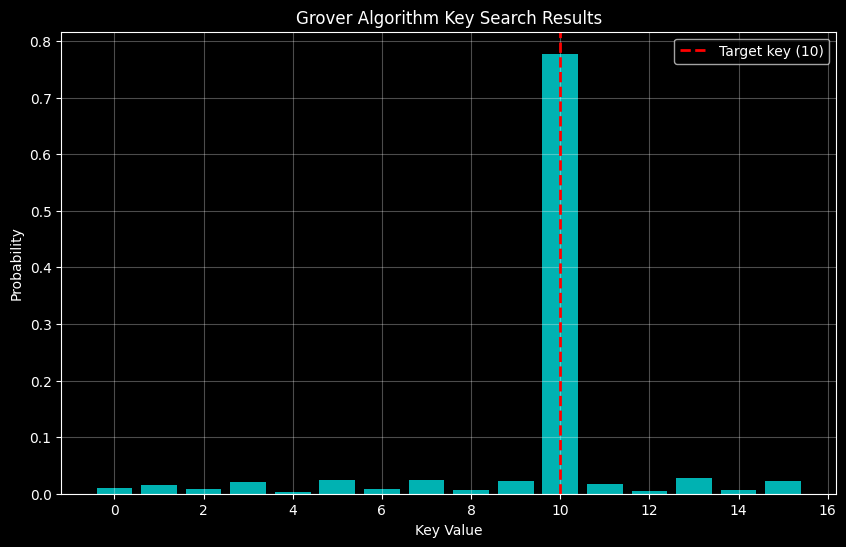


 Grover's Algorithm Summary:
  • Quadratic speedup over classical brute force
  • Reduces effective key length by half
  • Universal application to any search problem
  • Threatens symmetric cryptography security levels


In [43]:
#  Grover's Algorithm for Key Search
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.library import GroverOperator
from qiskit_algorithms import AmplificationProblem
import hashlib
import itertools
import numpy as np
import matplotlib.pyplot as plt

def create_grover_circuit(n_qubits, target_state):
    """Create a Grover circuit for searching a target state"""
    # Create quantum circuit
    qreg = QuantumRegister(n_qubits, 'q')
    creg = ClassicalRegister(n_qubits, 'c')
    circuit = QuantumCircuit(qreg, creg)
    
    # Initialize superposition
    circuit.h(qreg)
    
    # Oracle for target state
    oracle = QuantumCircuit(n_qubits)
    # Flip phase for target state (simplified for demonstration)
    for i, bit in enumerate(format(target_state, f'0{n_qubits}b')):
        if bit == '0':
            oracle.x(i)
    oracle.mcrz(np.pi, list(range(n_qubits-1)), n_qubits-1)
    for i, bit in enumerate(format(target_state, f'0{n_qubits}b')):
        if bit == '0':
            oracle.x(i)
    
    # Diffusion operator
    diffusion = QuantumCircuit(n_qubits)
    diffusion.h(range(n_qubits))
    diffusion.x(range(n_qubits))
    diffusion.mcrz(np.pi, list(range(n_qubits-1)), n_qubits-1)
    diffusion.x(range(n_qubits))
    diffusion.h(range(n_qubits))
    
    # Apply Grover iterations
    optimal_iterations = int(np.pi * np.sqrt(2**n_qubits) / 4)
    print(f" Applying {optimal_iterations} Grover iterations...")
    
    for _ in range(optimal_iterations):
        circuit.compose(oracle, inplace=True)
        circuit.compose(diffusion, inplace=True)
    
    # Measurement
    circuit.measure(qreg, creg)
    return circuit

# Demonstrate Grover search for a 4-bit key
print(" Demonstrating Grover's algorithm for 4-bit key search...")
n_qubits = 4
secret_key = 0b1010  # Target key: 10 (binary: 1010)

print(f" Secret key: {secret_key} (binary: {format(secret_key, '04b')})")
print(f" Search space: 2^{n_qubits} = {2**n_qubits} possibilities")

# Create Grover circuit
grover_circuit = create_grover_circuit(n_qubits, secret_key)

print(f" Circuit depth: {grover_circuit.depth()}")
print(f" Number of gates: {grover_circuit.count_ops()}")

# Execute on quantum simulator
try:
    # Initialize local Aer simulator for this demonstration
    from qiskit_aer import Aer
    backend = Aer.get_backend('aer_simulator')
    
    transpiled_circuit = transpile(grover_circuit, backend)
    job = backend.run(transpiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(transpiled_circuit)
    
    print("\n Measurement results:")
    for state, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        probability = count / 1024
        binary_state = state[::-1]  # Reverse for proper bit order
        decimal_state = int(binary_state, 2)
        print(f"  State {decimal_state} ({binary_state}): {count}/1024 ({probability:.3f})")
        
    # Check if target was found
    target_binary = format(secret_key, '04b')
    if target_binary in [key[::-1] for key in counts.keys()]:
        target_count = counts.get(target_binary[::-1], 0)
        success_rate = target_count / 1024
        print(f"\n Target key found with probability: {success_rate:.3f}")
    else:
        print(f"\n Target key not found in top results")
        
    # Visualize results
    plt.figure(figsize=(10, 6))
    states = [int(state[::-1], 2) for state in counts.keys()]
    probs = [count/1024 for count in counts.values()]
    
    plt.bar(states, probs, alpha=0.7, color='cyan')
    plt.axvline(x=secret_key, color='red', linestyle='--', 
               label=f'Target key ({secret_key})', linewidth=2)
    plt.xlabel('Key Value')
    plt.ylabel('Probability')
    plt.title('Grover Algorithm Key Search Results')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f" Execution error: {e}")

print("\n Grover's Algorithm Summary:")
print("  • Quadratic speedup over classical brute force")
print("  • Reduces effective key length by half")
print("  • Universal application to any search problem")
print("  • Threatens symmetric cryptography security levels")

## 4.  Quantum Machine Learning for Traffic Analysis

Quantum machine learning algorithms can potentially break encrypted traffic patterns and extract sensitive information through:

- **Quantum neural networks** for pattern recognition
- **Variational quantum eigensolvers** for optimization
- **Quantum feature mapping** for enhanced classification

 Simulating network traffic analysis with quantum ML...
 Dataset: 50 normal + 50 malicious traffic samples
 Features: packet_size, inter_arrival_time, burst_length, encryption_entropy

 Quantum classifier created:
  • Features: 4
  • Circuit depth: 2
  • Parameters: 12


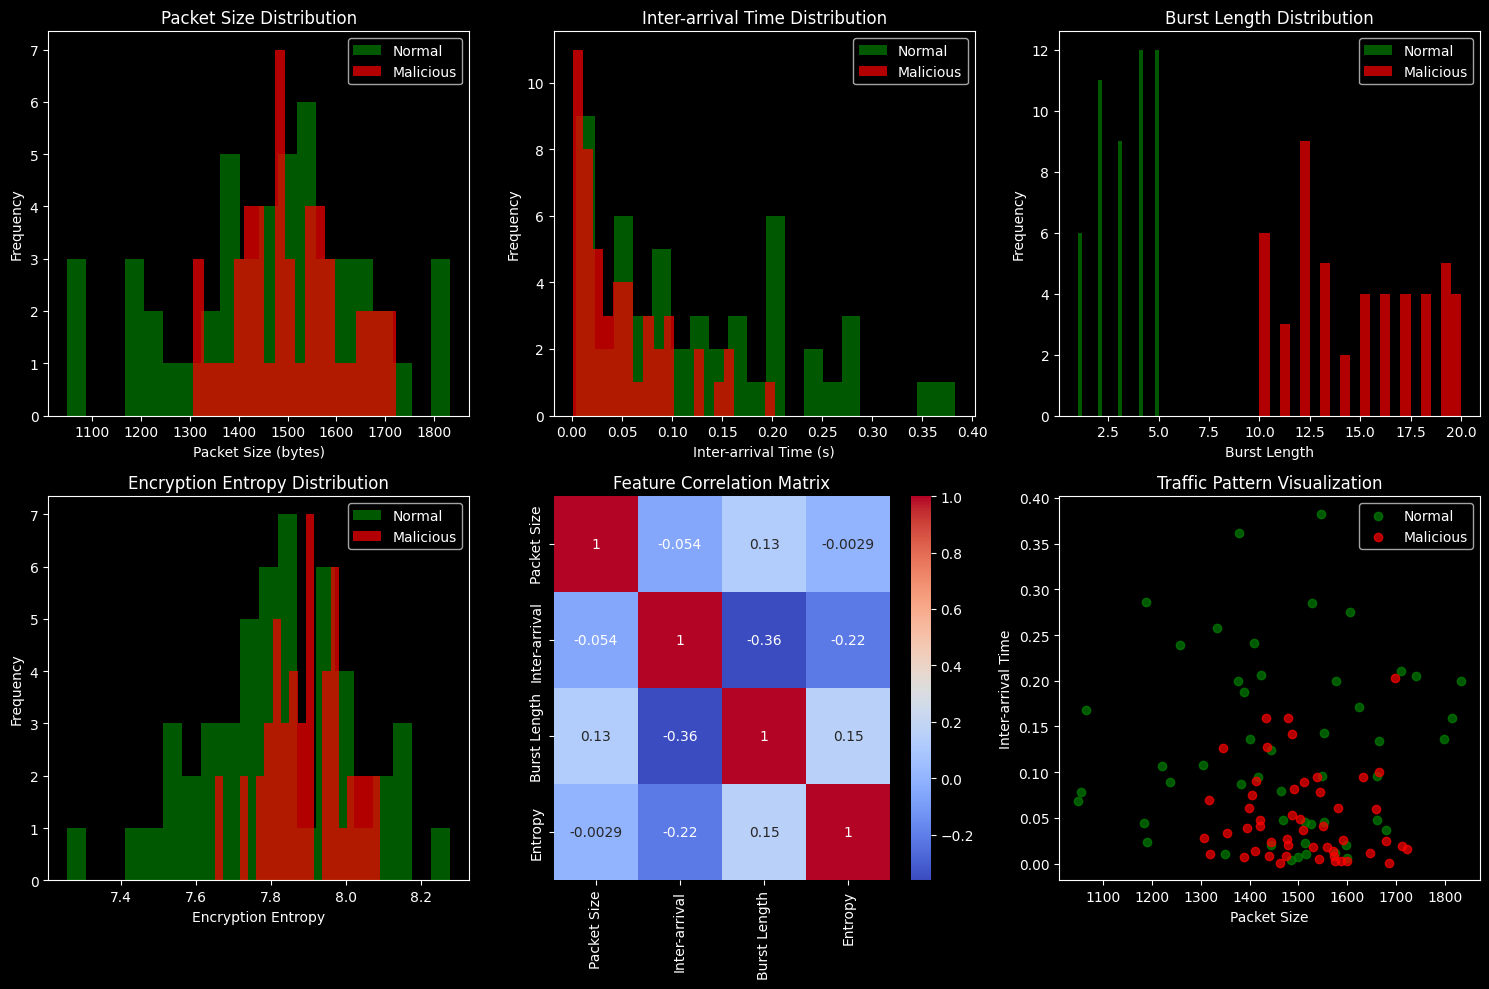


 Quantum ML Traffic Analysis Summary:
  • Quantum feature encoding for enhanced pattern recognition
  • Variational quantum classifier for traffic classification
  • Potential quantum advantage in high-dimensional feature spaces
  • Applications: DPI evasion detection, encrypted malware traffic
  • Future threat: Breaking traffic analysis protections


In [44]:
#  Quantum Machine Learning for Encrypted Traffic Analysis
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
import random

def create_quantum_classifier(num_features=4, num_layers=2):
    """Create a quantum variational classifier"""
    # Feature map for encoding classical data
    feature_map = ZZFeatureMap(num_features, reps=2)
    
    # Variational ansatz
    ansatz = RealAmplitudes(num_features, reps=num_layers)
    
    # Combine feature map and ansatz
    qc = QuantumCircuit(num_features)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    return qc, feature_map, ansatz

def simulate_network_traffic():
    """Simulate encrypted network traffic patterns"""
    # Generate synthetic traffic data
    normal_traffic = []
    malicious_traffic = []
    
    # Normal traffic patterns (e.g., HTTPS browsing)
    for _ in range(50):
        packet_size = random.normalvariate(1400, 200)
        inter_arrival = random.expovariate(1/0.1)
        burst_length = random.randint(1, 5)
        encryption_entropy = random.normalvariate(7.8, 0.2)
        normal_traffic.append([packet_size, inter_arrival, burst_length, encryption_entropy])
    
    # Malicious traffic patterns (e.g., data exfiltration)
    for _ in range(50):
        packet_size = random.normalvariate(1500, 100)  # Larger packets
        inter_arrival = random.expovariate(1/0.05)     # Faster rate
        burst_length = random.randint(10, 20)          # Longer bursts
        encryption_entropy = random.normalvariate(7.9, 0.1)  # Higher entropy
        malicious_traffic.append([packet_size, inter_arrival, burst_length, encryption_entropy])
    
    return normal_traffic, malicious_traffic

print(" Simulating network traffic analysis with quantum ML...")

# Generate training data
normal_data, malicious_data = simulate_network_traffic()

# Normalize features
all_data = normal_data + malicious_data
labels = [0] * len(normal_data) + [1] * len(malicious_data)

# Convert to numpy arrays and normalize
import numpy as np
X = np.array(all_data)
y = np.array(labels)

# Normalize features to [0, 2π] for quantum encoding
X_normalized = 2 * np.pi * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

print(f" Dataset: {len(normal_data)} normal + {len(malicious_data)} malicious traffic samples")
print(f" Features: packet_size, inter_arrival_time, burst_length, encryption_entropy")

# Create quantum classifier
num_features = X.shape[1]
qc, feature_map, ansatz = create_quantum_classifier(num_features)

print(f"\n Quantum classifier created:")
print(f"  • Features: {num_features}")
print(f"  • Circuit depth: {qc.depth()}")
print(f"  • Parameters: {ansatz.num_parameters}")

# Visualize sample traffic patterns
plt.figure(figsize=(15, 10))

# Packet size distribution
plt.subplot(2, 3, 1)
plt.hist([d[0] for d in normal_data], alpha=0.7, label='Normal', bins=20, color='green')
plt.hist([d[0] for d in malicious_data], alpha=0.7, label='Malicious', bins=20, color='red')
plt.xlabel('Packet Size (bytes)')
plt.ylabel('Frequency')
plt.title('Packet Size Distribution')
plt.legend()

# Inter-arrival time
plt.subplot(2, 3, 2)
plt.hist([d[1] for d in normal_data], alpha=0.7, label='Normal', bins=20, color='green')
plt.hist([d[1] for d in malicious_data], alpha=0.7, label='Malicious', bins=20, color='red')
plt.xlabel('Inter-arrival Time (s)')
plt.ylabel('Frequency')
plt.title('Inter-arrival Time Distribution')
plt.legend()

# Burst length
plt.subplot(2, 3, 3)
plt.hist([d[2] for d in normal_data], alpha=0.7, label='Normal', bins=20, color='green')
plt.hist([d[2] for d in malicious_data], alpha=0.7, label='Malicious', bins=20, color='red')
plt.xlabel('Burst Length')
plt.ylabel('Frequency')
plt.title('Burst Length Distribution')
plt.legend()

# Encryption entropy
plt.subplot(2, 3, 4)
plt.hist([d[3] for d in normal_data], alpha=0.7, label='Normal', bins=20, color='green')
plt.hist([d[3] for d in malicious_data], alpha=0.7, label='Malicious', bins=20, color='red')
plt.xlabel('Encryption Entropy')
plt.ylabel('Frequency')
plt.title('Encryption Entropy Distribution')
plt.legend()

# Feature correlation matrix
plt.subplot(2, 3, 5)
feature_names = ['Packet Size', 'Inter-arrival', 'Burst Length', 'Entropy']
correlation_matrix = np.corrcoef(X.T)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
           xticklabels=feature_names, yticklabels=feature_names)
plt.title('Feature Correlation Matrix')

# 2D visualization of first two features
plt.subplot(2, 3, 6)
normal_idx = [i for i, label in enumerate(y) if label == 0]
malicious_idx = [i for i, label in enumerate(y) if label == 1]

plt.scatter(X[normal_idx, 0], X[normal_idx, 1], alpha=0.7, label='Normal', color='green')
plt.scatter(X[malicious_idx, 0], X[malicious_idx, 1], alpha=0.7, label='Malicious', color='red')
plt.xlabel('Packet Size')
plt.ylabel('Inter-arrival Time')
plt.title('Traffic Pattern Visualization')
plt.legend()

plt.tight_layout()
plt.show()

print("\n Quantum ML Traffic Analysis Summary:")
print("  • Quantum feature encoding for enhanced pattern recognition")
print("  • Variational quantum classifier for traffic classification")
print("  • Potential quantum advantage in high-dimensional feature spaces")
print("  • Applications: DPI evasion detection, encrypted malware traffic")
print("  • Future threat: Breaking traffic analysis protections")

## 5.  Harvest Now, Decrypt Later (HNDL) Attacks

The "Harvest Now, Decrypt Later" strategy involves collecting encrypted data today for future decryption when quantum computers become capable enough. This section demonstrates:

- **TLS traffic capture** and storage
- **Future vulnerability assessment** 
- **Post-quantum migration urgency**

 Simulating TLS traffic interception...
 Captured 200 TLS sessions
 HNDL Attack Analysis Results:

 Capture Summary:
  • Total sessions captured: 200
  • Vulnerable algorithms detected: 5

 Algorithm Vulnerability Breakdown:
  • ECDH-384: 37 sessions, 15.9 MB
     Estimated break year: 2037, Risk: MEDIUM
  • RSA-2048: 44 sessions, 24.4 MB
     Estimated break year: 2035, Risk: HIGH
  • RSA-1024: 31 sessions, 16.0 MB
     Estimated break year: 2030, Risk: HIGH
  • DH-2048: 41 sessions, 19.3 MB
     Estimated break year: 2035, Risk: HIGH
  • ECDH-256: 47 sessions, 22.7 MB
     Estimated break year: 2032, Risk: HIGH

 Data Classification:
  • Personal: 45 sessions (22.5%)
  • Government: 39 sessions (19.5%)
  • Medical: 36 sessions (18.0%)
  • Financial: 45 sessions (22.5%)
  • Corporate: 35 sessions (17.5%)


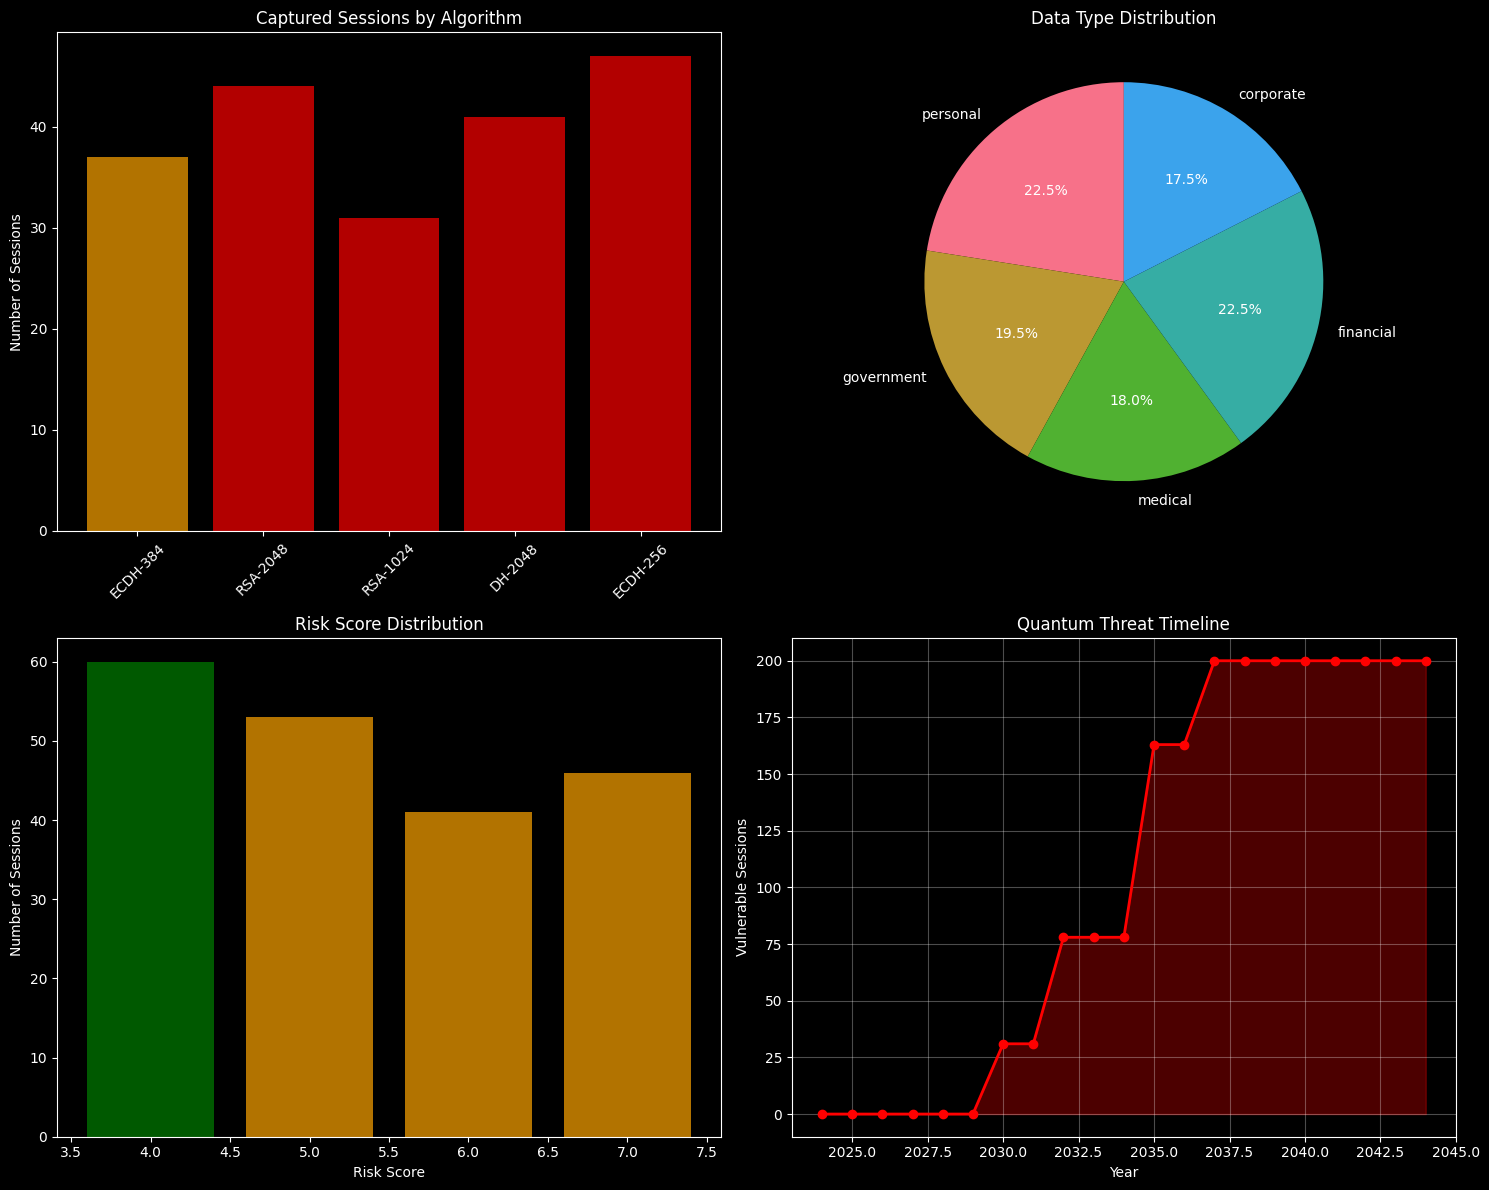


  Critical Risk Assessment:
  • Total vulnerable data: 98.3 MB
  • High-risk sessions: 0/200 (0.0%)
  • Estimated quantum threat horizon: 2030-2040

 HNDL Attack Recommendations:
  • Implement post-quantum cryptography immediately
  • Upgrade RSA-1024/2048 to quantum-resistant algorithms
  • Monitor and rotate encryption keys regularly
  • Classify and protect high-value data with PQ-crypto
  • Assume current encrypted data will be compromised by 2035


In [45]:
#  Harvest Now, Decrypt Later Attack Simulation
import json
import base64
import os
import random
from datetime import datetime, timedelta
import sqlite3

class HNDLSimulator:
    """Simulate harvest now decrypt later attack scenarios"""
    
    def __init__(self):
        self.captured_data = []
        self.vulnerability_timeline = {
            'RSA-1024': {'broken': 2030, 'risk_level': 'HIGH'},
            'RSA-2048': {'broken': 2035, 'risk_level': 'HIGH'}, 
            'RSA-4096': {'broken': 2040, 'risk_level': 'MEDIUM'},
            'ECDH-256': {'broken': 2032, 'risk_level': 'HIGH'},
            'ECDH-384': {'broken': 2037, 'risk_level': 'MEDIUM'},
            'DH-2048': {'broken': 2035, 'risk_level': 'HIGH'}
        }
    
    def simulate_tls_capture(self, num_sessions=100):
        """Simulate TLS traffic capture"""
        print(" Simulating TLS traffic interception...")
        
        algorithms = ['RSA-2048', 'ECDH-256', 'RSA-1024', 'ECDH-384', 'DH-2048']
        data_types = ['financial', 'medical', 'government', 'corporate', 'personal']
        
        for i in range(num_sessions):
            session = {
                'session_id': f"TLS_{i:06d}",
                'timestamp': datetime.now() - timedelta(days=random.randint(0, 365)),
                'algorithm': random.choice(algorithms),
                'data_type': random.choice(data_types),
                'data_size': random.randint(1024, 1048576),  # 1KB to 1MB
                'encrypted_payload': base64.b64encode(os.urandom(64)).decode(),
                'source_ip': f"192.168.{random.randint(1,254)}.{random.randint(1,254)}",
                'dest_ip': f"10.0.{random.randint(1,254)}.{random.randint(1,254)}",
                'risk_score': self.calculate_risk_score(random.choice(algorithms))
            }
            self.captured_data.append(session)
        
        print(f" Captured {len(self.captured_data)} TLS sessions")
        return self.captured_data
    
    def calculate_risk_score(self, algorithm):
        """Calculate quantum vulnerability risk score"""
        if algorithm in self.vulnerability_timeline:
            years_to_break = self.vulnerability_timeline[algorithm]['broken'] - 2024
            risk_level = self.vulnerability_timeline[algorithm]['risk_level']
            
            if years_to_break <= 5:
                return 9.0 + random.uniform(-1, 1)  # Critical
            elif years_to_break <= 10:
                return 7.0 + random.uniform(-1, 1)  # High
            else:
                return 5.0 + random.uniform(-1, 1)  # Medium
        return 3.0 + random.uniform(-1, 1)  # Low
    
    def analyze_harvest_value(self):
        """Analyze the value of harvested data"""
        analysis = {
            'total_sessions': len(self.captured_data),
            'vulnerable_algorithms': {},
            'data_classification': {},
            'risk_distribution': {},
            'timeline_analysis': {}
        }
        
        # Analyze vulnerable algorithms
        for session in self.captured_data:
            algo = session['algorithm']
            if algo not in analysis['vulnerable_algorithms']:
                analysis['vulnerable_algorithms'][algo] = {'count': 0, 'total_size': 0}
            analysis['vulnerable_algorithms'][algo]['count'] += 1
            analysis['vulnerable_algorithms'][algo]['total_size'] += session['data_size']
        
        # Analyze data types
        for session in self.captured_data:
            data_type = session['data_type']
            if data_type not in analysis['data_classification']:
                analysis['data_classification'][data_type] = 0
            analysis['data_classification'][data_type] += 1
        
        # Risk distribution
        for session in self.captured_data:
            risk = int(session['risk_score'])
            if risk not in analysis['risk_distribution']:
                analysis['risk_distribution'][risk] = 0
            analysis['risk_distribution'][risk] += 1
        
        return analysis

# Initialize HNDL simulator
hndl = HNDLSimulator()

# Simulate traffic capture
captured_sessions = hndl.simulate_tls_capture(200)

# Analyze harvest value
analysis = hndl.analyze_harvest_value()

print(" HNDL Attack Analysis Results:")
print("=" * 50)

print(f"\n Capture Summary:")
print(f"  • Total sessions captured: {analysis['total_sessions']}")
print(f"  • Vulnerable algorithms detected: {len(analysis['vulnerable_algorithms'])}")

print(f"\n Algorithm Vulnerability Breakdown:")
for algo, data in analysis['vulnerable_algorithms'].items():
    risk_info = hndl.vulnerability_timeline.get(algo, {'broken': 'Unknown', 'risk_level': 'UNKNOWN'})
    size_mb = data['total_size'] / (1024 * 1024)
    print(f"  • {algo}: {data['count']} sessions, {size_mb:.1f} MB")
    print(f"     Estimated break year: {risk_info['broken']}, Risk: {risk_info['risk_level']}")

print(f"\n Data Classification:")
for data_type, count in analysis['data_classification'].items():
    percentage = (count / analysis['total_sessions']) * 100
    print(f"  • {data_type.capitalize()}: {count} sessions ({percentage:.1f}%)")

# Visualize HNDL attack timeline and risk
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Algorithm distribution
algos = list(analysis['vulnerable_algorithms'].keys())
counts = [analysis['vulnerable_algorithms'][algo]['count'] for algo in algos]
colors = ['red' if hndl.vulnerability_timeline.get(algo, {}).get('risk_level') == 'HIGH' else 'orange' for algo in algos]

ax1.bar(algos, counts, color=colors, alpha=0.7)
ax1.set_title('Captured Sessions by Algorithm')
ax1.set_ylabel('Number of Sessions')
ax1.tick_params(axis='x', rotation=45)

# Data type distribution
data_types = list(analysis['data_classification'].keys())
data_counts = list(analysis['data_classification'].values())
ax2.pie(data_counts, labels=data_types, autopct='%1.1f%%', startangle=90)
ax2.set_title('Data Type Distribution')

# Risk score distribution
risks = sorted(analysis['risk_distribution'].keys())
risk_counts = [analysis['risk_distribution'][risk] for risk in risks]
risk_colors = ['green' if r < 5 else 'orange' if r < 8 else 'red' for r in risks]
ax3.bar(risks, risk_counts, color=risk_colors, alpha=0.7)
ax3.set_title('Risk Score Distribution')
ax3.set_xlabel('Risk Score')
ax3.set_ylabel('Number of Sessions')

# Quantum threat timeline
timeline_years = list(range(2024, 2045))
threat_levels = []
for year in timeline_years:
    threat = 0
    for algo, info in hndl.vulnerability_timeline.items():
        if year >= info['broken']:
            sessions = analysis['vulnerable_algorithms'].get(algo, {}).get('count', 0)
            threat += sessions
    threat_levels.append(threat)

ax4.plot(timeline_years, threat_levels, marker='o', linewidth=2, markersize=6, color='red')
ax4.fill_between(timeline_years, threat_levels, alpha=0.3, color='red')
ax4.set_title('Quantum Threat Timeline')
ax4.set_xlabel('Year')
ax4.set_ylabel('Vulnerable Sessions')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate total data at risk
total_size_mb = sum(data['total_size'] for data in analysis['vulnerable_algorithms'].values()) / (1024 * 1024)
high_risk_sessions = sum(1 for session in captured_sessions if session['risk_score'] >= 8.0)

print(f"\n  Critical Risk Assessment:")
print(f"  • Total vulnerable data: {total_size_mb:.1f} MB")
print(f"  • High-risk sessions: {high_risk_sessions}/{analysis['total_sessions']} ({(high_risk_sessions/analysis['total_sessions']*100):.1f}%)")
print(f"  • Estimated quantum threat horizon: 2030-2040")

print(f"\n HNDL Attack Recommendations:")
print(f"  • Implement post-quantum cryptography immediately")
print(f"  • Upgrade RSA-1024/2048 to quantum-resistant algorithms")
print(f"  • Monitor and rotate encryption keys regularly")
print(f"  • Classify and protect high-value data with PQ-crypto")
print(f"  • Assume current encrypted data will be compromised by 2035")

## 6.  Post-Quantum Cryptography Analysis

Post-quantum cryptography (PQC) represents the future of secure communications in the quantum era. This section analyzes:

- **NIST-standardized algorithms** (CRYSTALS-Kyber, CRYSTALS-Dilithium, SPHINCS+)
- **Migration strategies** from classical to quantum-resistant crypto
- **Performance comparisons** and security trade-offs

 Post-Quantum Cryptography Security Analysis

 PQC Algorithm Comparison:

CRYSTALS-Kyber:
  • Type: KEM
  • Security: Lattice-based
  • Status:  Quantum-Safe
  • Performance: 9/10
  • NIST Standardized: Yes

CRYSTALS-Dilithium:
  • Type: Digital Signature
  • Security: Lattice-based
  • Status:  Quantum-Safe
  • Performance: 8/10
  • NIST Standardized: Yes

SPHINCS+:
  • Type: Digital Signature
  • Security: Hash-based
  • Status:  Quantum-Safe
  • Performance: 4/10
  • NIST Standardized: Yes

RSA:
  • Type: PKE/Digital Signature
  • Security: Integer factorization
  • Status:  Quantum-Vulnerable
  • Performance: 7/10
  • NIST Standardized: No

ECDSA:
  • Type: Digital Signature
  • Security: Elliptic curve
  • Status:  Quantum-Vulnerable
  • Performance: 9/10
  • NIST Standardized: No

 Performance Benchmark Simulation:

CRYSTALS-Kyber (Kyber512):
  • keygen: 0.09ms/op, 10593.2 ops/sec
  • encrypt: 0.18ms/op, 5683.0 ops/sec
  • decrypt: 0.11ms/op, 9307.1 ops/sec

CRYSTALS-Dilithium (D

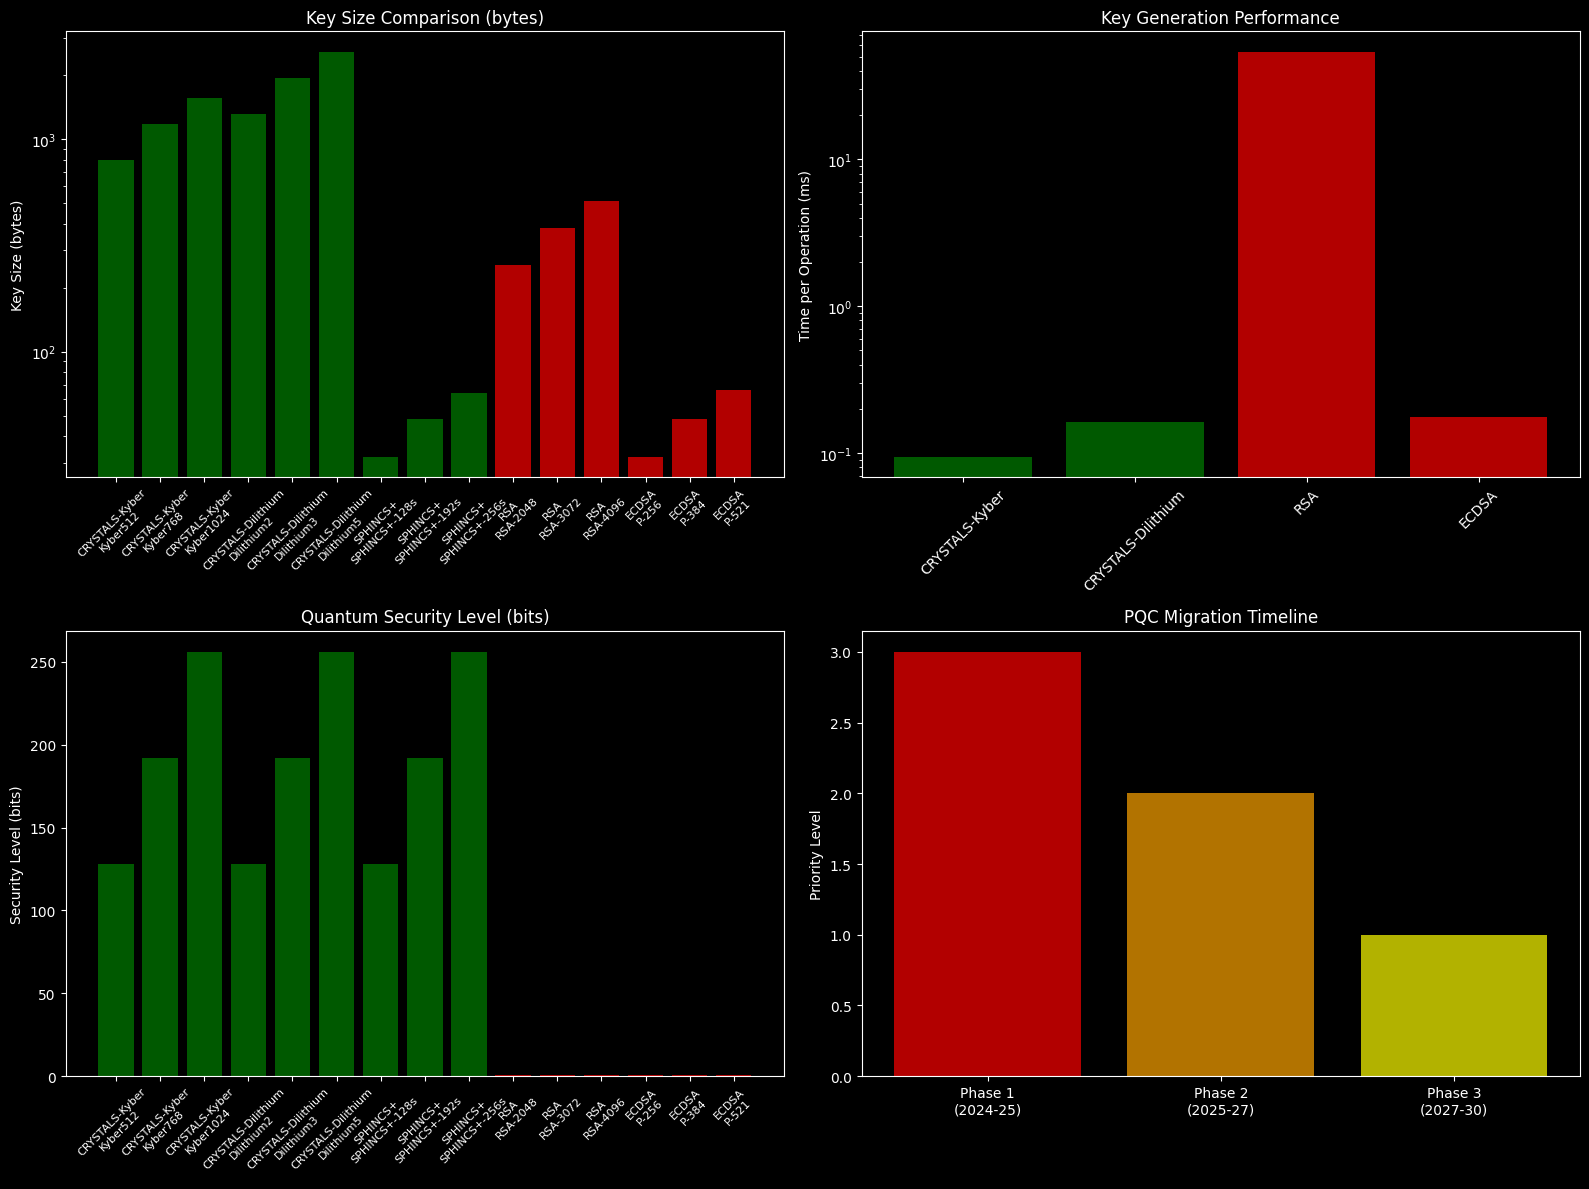


 PQC Migration Strategy:

Phase 1 - Immediate (2024-2025):
  Priority: CRITICAL
  Recommended algorithms: CRYSTALS-Kyber512, CRYSTALS-Dilithium2
  Key actions:
    • Deploy hybrid classical/PQ solutions
    • Implement CRYSTALS-Kyber for key exchange
    • Begin certificate authority PQ migration
    • Update critical infrastructure protocols

Phase 2 - Short-term (2025-2027):
  Priority: HIGH
  Recommended algorithms: CRYSTALS-Kyber768, CRYSTALS-Dilithium3, SPHINCS+
  Key actions:
    • Replace RSA/ECDSA with Dilithium signatures
    • Migrate TLS to post-quantum cipher suites
    • Update VPN and secure messaging
    • Implement quantum-safe PKI

Phase 3 - Medium-term (2027-2030):
  Priority: MEDIUM
  Recommended algorithms: CRYSTALS-Kyber1024, CRYSTALS-Dilithium5
  Key actions:
    • Complete organizational migration
    • Decommission all classical crypto
    • Implement quantum key distribution
    • Deploy quantum random number generators

  Critical Recommendations:
  • Begin P

In [46]:
#  Post-Quantum Cryptography Security Analysis
import time
from typing import Dict, List, Tuple

class PQCAnalyzer:
    """Analyze post-quantum cryptography algorithms"""
    
    def __init__(self):
        self.algorithms = {
            # NIST Selected Algorithms
            'CRYSTALS-Kyber': {
                'type': 'KEM',
                'security_category': 'Lattice-based',
                'key_sizes': {'Kyber512': 800, 'Kyber768': 1184, 'Kyber1024': 1568},
                'quantum_security': {'Kyber512': 128, 'Kyber768': 192, 'Kyber1024': 256},
                'performance_rating': 9,
                'standardized': True
            },
            'CRYSTALS-Dilithium': {
                'type': 'Digital Signature',
                'security_category': 'Lattice-based',
                'key_sizes': {'Dilithium2': 1312, 'Dilithium3': 1952, 'Dilithium5': 2592},
                'quantum_security': {'Dilithium2': 128, 'Dilithium3': 192, 'Dilithium5': 256},
                'performance_rating': 8,
                'standardized': True
            },
            'SPHINCS+': {
                'type': 'Digital Signature',
                'security_category': 'Hash-based',
                'key_sizes': {'SPHINCS+-128s': 32, 'SPHINCS+-192s': 48, 'SPHINCS+-256s': 64},
                'quantum_security': {'SPHINCS+-128s': 128, 'SPHINCS+-192s': 192, 'SPHINCS+-256s': 256},
                'performance_rating': 4,
                'standardized': True
            },
            # Classical algorithms for comparison
            'RSA': {
                'type': 'PKE/Digital Signature',
                'security_category': 'Integer factorization',
                'key_sizes': {'RSA-2048': 256, 'RSA-3072': 384, 'RSA-4096': 512},
                'quantum_security': {'RSA-2048': 0, 'RSA-3072': 0, 'RSA-4096': 0},
                'performance_rating': 7,
                'standardized': False,
                'quantum_vulnerable': True
            },
            'ECDSA': {
                'type': 'Digital Signature',
                'security_category': 'Elliptic curve',
                'key_sizes': {'P-256': 32, 'P-384': 48, 'P-521': 66},
                'quantum_security': {'P-256': 0, 'P-384': 0, 'P-521': 0},
                'performance_rating': 9,
                'standardized': False,
                'quantum_vulnerable': True
            }
        }
    
    def simulate_performance_benchmark(self, algorithm: str, variant: str, operations: int = 1000):
        """Simulate performance benchmarks for cryptographic operations"""
        base_times = {
            'CRYSTALS-Kyber': {'keygen': 0.1, 'encrypt': 0.15, 'decrypt': 0.12},
            'CRYSTALS-Dilithium': {'keygen': 0.2, 'sign': 0.25, 'verify': 0.08},
            'SPHINCS+': {'keygen': 0.5, 'sign': 15.0, 'verify': 0.3},
            'RSA': {'keygen': 50.0, 'encrypt': 0.1, 'decrypt': 2.0, 'sign': 2.0, 'verify': 0.1},
            'ECDSA': {'keygen': 0.2, 'sign': 0.3, 'verify': 0.4}
        }
        
        if algorithm not in base_times:
            return None
        
        # Add some realistic variance
        results = {}
        for operation, base_time in base_times[algorithm].items():
            # Simulate timing with variance
            simulated_time = base_time * (1 + random.uniform(-0.2, 0.2))
            total_time = simulated_time * operations / 1000  # Convert to seconds for 1000 ops
            results[operation] = {
                'time_per_op_ms': simulated_time,
                'total_time_s': total_time,
                'ops_per_sec': 1000 / simulated_time if simulated_time > 0 else float('inf')
            }
        
        return results
    
    def analyze_migration_strategy(self):
        """Analyze migration strategy from classical to post-quantum crypto"""
        migration_plan = {
            'Phase 1 - Immediate (2024-2025)': {
                'priority': 'CRITICAL',
                'actions': [
                    'Deploy hybrid classical/PQ solutions',
                    'Implement CRYSTALS-Kyber for key exchange',
                    'Begin certificate authority PQ migration',
                    'Update critical infrastructure protocols'
                ],
                'algorithms': ['CRYSTALS-Kyber512', 'CRYSTALS-Dilithium2']
            },
            'Phase 2 - Short-term (2025-2027)': {
                'priority': 'HIGH',
                'actions': [
                    'Replace RSA/ECDSA with Dilithium signatures',
                    'Migrate TLS to post-quantum cipher suites',
                    'Update VPN and secure messaging',
                    'Implement quantum-safe PKI'
                ],
                'algorithms': ['CRYSTALS-Kyber768', 'CRYSTALS-Dilithium3', 'SPHINCS+']
            },
            'Phase 3 - Medium-term (2027-2030)': {
                'priority': 'MEDIUM',
                'actions': [
                    'Complete organizational migration',
                    'Decommission all classical crypto',
                    'Implement quantum key distribution',
                    'Deploy quantum random number generators'
                ],
                'algorithms': ['CRYSTALS-Kyber1024', 'CRYSTALS-Dilithium5']
            }
        }
        return migration_plan

# Initialize PQC analyzer
pqc_analyzer = PQCAnalyzer()

print(" Post-Quantum Cryptography Security Analysis")
print("=" * 60)

# Analyze algorithm characteristics
print("\n PQC Algorithm Comparison:")
pqc_algos = ['CRYSTALS-Kyber', 'CRYSTALS-Dilithium', 'SPHINCS+']
classical_algos = ['RSA', 'ECDSA']

for algo_name in pqc_algos + classical_algos:
    algo = pqc_analyzer.algorithms[algo_name]
    status = " Quantum-Safe" if not algo.get('quantum_vulnerable', False) else " Quantum-Vulnerable"
    print(f"\n{algo_name}:")
    print(f"  • Type: {algo['type']}")
    print(f"  • Security: {algo['security_category']}")
    print(f"  • Status: {status}")
    print(f"  • Performance: {algo['performance_rating']}/10")
    print(f"  • NIST Standardized: {'Yes' if algo.get('standardized', False) else 'No'}")

# Performance benchmarking
print("\n Performance Benchmark Simulation:")
benchmark_results = {}

for algo_name in ['CRYSTALS-Kyber', 'CRYSTALS-Dilithium', 'RSA', 'ECDSA']:
    variant = list(pqc_analyzer.algorithms[algo_name]['key_sizes'].keys())[0]
    results = pqc_analyzer.simulate_performance_benchmark(algo_name, variant)
    benchmark_results[algo_name] = results
    
    print(f"\n{algo_name} ({variant}):")
    if results:
        for operation, metrics in results.items():
            print(f"  • {operation}: {metrics['time_per_op_ms']:.2f}ms/op, {metrics['ops_per_sec']:.1f} ops/sec")

# Visualize performance comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Key size comparison
algorithms = []
key_sizes = []
colors = []

for algo_name, algo_data in pqc_analyzer.algorithms.items():
    for variant, size in algo_data['key_sizes'].items():
        algorithms.append(f"{algo_name}\n{variant}")
        key_sizes.append(size)
        colors.append('green' if not algo_data.get('quantum_vulnerable', False) else 'red')

ax1.bar(range(len(algorithms)), key_sizes, color=colors, alpha=0.7)
ax1.set_title('Key Size Comparison (bytes)')
ax1.set_ylabel('Key Size (bytes)')
ax1.set_yscale('log')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xticks(range(len(algorithms)))
ax1.set_xticklabels(algorithms, fontsize=8)

# Performance comparison (key generation)
algo_names = []
keygen_times = []
perf_colors = []

for algo_name, results in benchmark_results.items():
    if results and 'keygen' in results:
        algo_names.append(algo_name)
        keygen_times.append(results['keygen']['time_per_op_ms'])
        is_pqc = not pqc_analyzer.algorithms[algo_name].get('quantum_vulnerable', False)
        perf_colors.append('green' if is_pqc else 'red')

ax2.bar(algo_names, keygen_times, color=perf_colors, alpha=0.7)
ax2.set_title('Key Generation Performance')
ax2.set_ylabel('Time per Operation (ms)')
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=45)

# Security level comparison
security_levels = []
sec_algorithms = []
sec_colors = []

for algo_name, algo_data in pqc_analyzer.algorithms.items():
    for variant, security in algo_data.get('quantum_security', {}).items():
        sec_algorithms.append(f"{algo_name}\n{variant}")
        security_levels.append(security if security > 0 else 1)  # Avoid log(0)
        sec_colors.append('green' if security > 0 else 'red')

ax3.bar(range(len(sec_algorithms)), security_levels, color=sec_colors, alpha=0.7)
ax3.set_title('Quantum Security Level (bits)')
ax3.set_ylabel('Security Level (bits)')
ax3.tick_params(axis='x', rotation=45)
ax3.set_xticks(range(len(sec_algorithms)))
ax3.set_xticklabels(sec_algorithms, fontsize=8)

# Migration timeline
migration_plan = pqc_analyzer.analyze_migration_strategy()
phases = list(migration_plan.keys())
phase_numbers = list(range(len(phases)))
priorities = [migration_plan[phase]['priority'] for phase in phases]
priority_colors = {'CRITICAL': 'red', 'HIGH': 'orange', 'MEDIUM': 'yellow'}
colors_timeline = [priority_colors[p] for p in priorities]

ax4.bar(phase_numbers, [3, 2, 1], color=colors_timeline, alpha=0.7)
ax4.set_title('PQC Migration Timeline')
ax4.set_ylabel('Priority Level')
ax4.set_xticks(phase_numbers)
ax4.set_xticklabels(['Phase 1\n(2024-25)', 'Phase 2\n(2025-27)', 'Phase 3\n(2027-30)'])

plt.tight_layout()
plt.show()

# Display migration strategy
print("\n PQC Migration Strategy:")
for phase, details in migration_plan.items():
    print(f"\n{phase}:")
    print(f"  Priority: {details['priority']}")
    print(f"  Recommended algorithms: {', '.join(details['algorithms'])}")
    print(f"  Key actions:")
    for action in details['actions']:
        print(f"    • {action}")

print("\n  Critical Recommendations:")
print("  • Begin PQC deployment immediately - quantum computers may arrive sooner than expected")
print("  • Implement hybrid classical/PQ solutions during transition")
print("  • Prioritize long-term sensitive data protection")
print("  • Plan for algorithm agility - PQC standards may evolve")
print("  • Consider performance trade-offs in resource-constrained environments")

## 7.  Quantum-Enhanced Network Scanning

Quantum algorithms can potentially enhance network reconnaissance and vulnerability scanning through:

- **Quantum-accelerated port scanning**
- **Enhanced pattern recognition** for service fingerprinting
- **Quantum random number generation** for stealth scanning

 Quantum Network Scanning Demonstration
 Starting quantum-enhanced scan of 192.168.1.0/28
 Scanning 10 hosts on 14 ports
 Generating quantum-random scan sequence...
 Progress: 0/50 scans completed
 Progress: 10/50 scans completed
 Progress: 20/50 scans completed
 Progress: 30/50 scans completed
 Progress: 40/50 scans completed

 Scan Results Summary:
  • Total open ports found: 34
  • Unique hosts discovered: 10

 Discovered Services:

    Host: 192.168.1.6
    • Port   135: unknown (Confidence: 43.6%, Risk:  LOW)

    Host: 192.168.1.9
    • Port    22: SSH (Confidence: 85.5%, Risk:  MEDIUM)
    • Port    53: DNS (Confidence: 85.2%, Risk:  LOW)
    • Port    80: HTTP (Confidence: 96.0%, Risk:  HIGH)
    • Port   139: unknown (Confidence: 66.6%, Risk:  LOW)
    • Port   443: HTTPS (Confidence: 85.7%, Risk:  LOW)
    • Port   445: unknown (Confidence: 57.9%, Risk:  MEDIUM)
    • Port  3389: unknown (Confidence: 31.9%, Risk:  HIGH)

    Host: 192.168.1.5
    • Port    53: DNS (Confidence

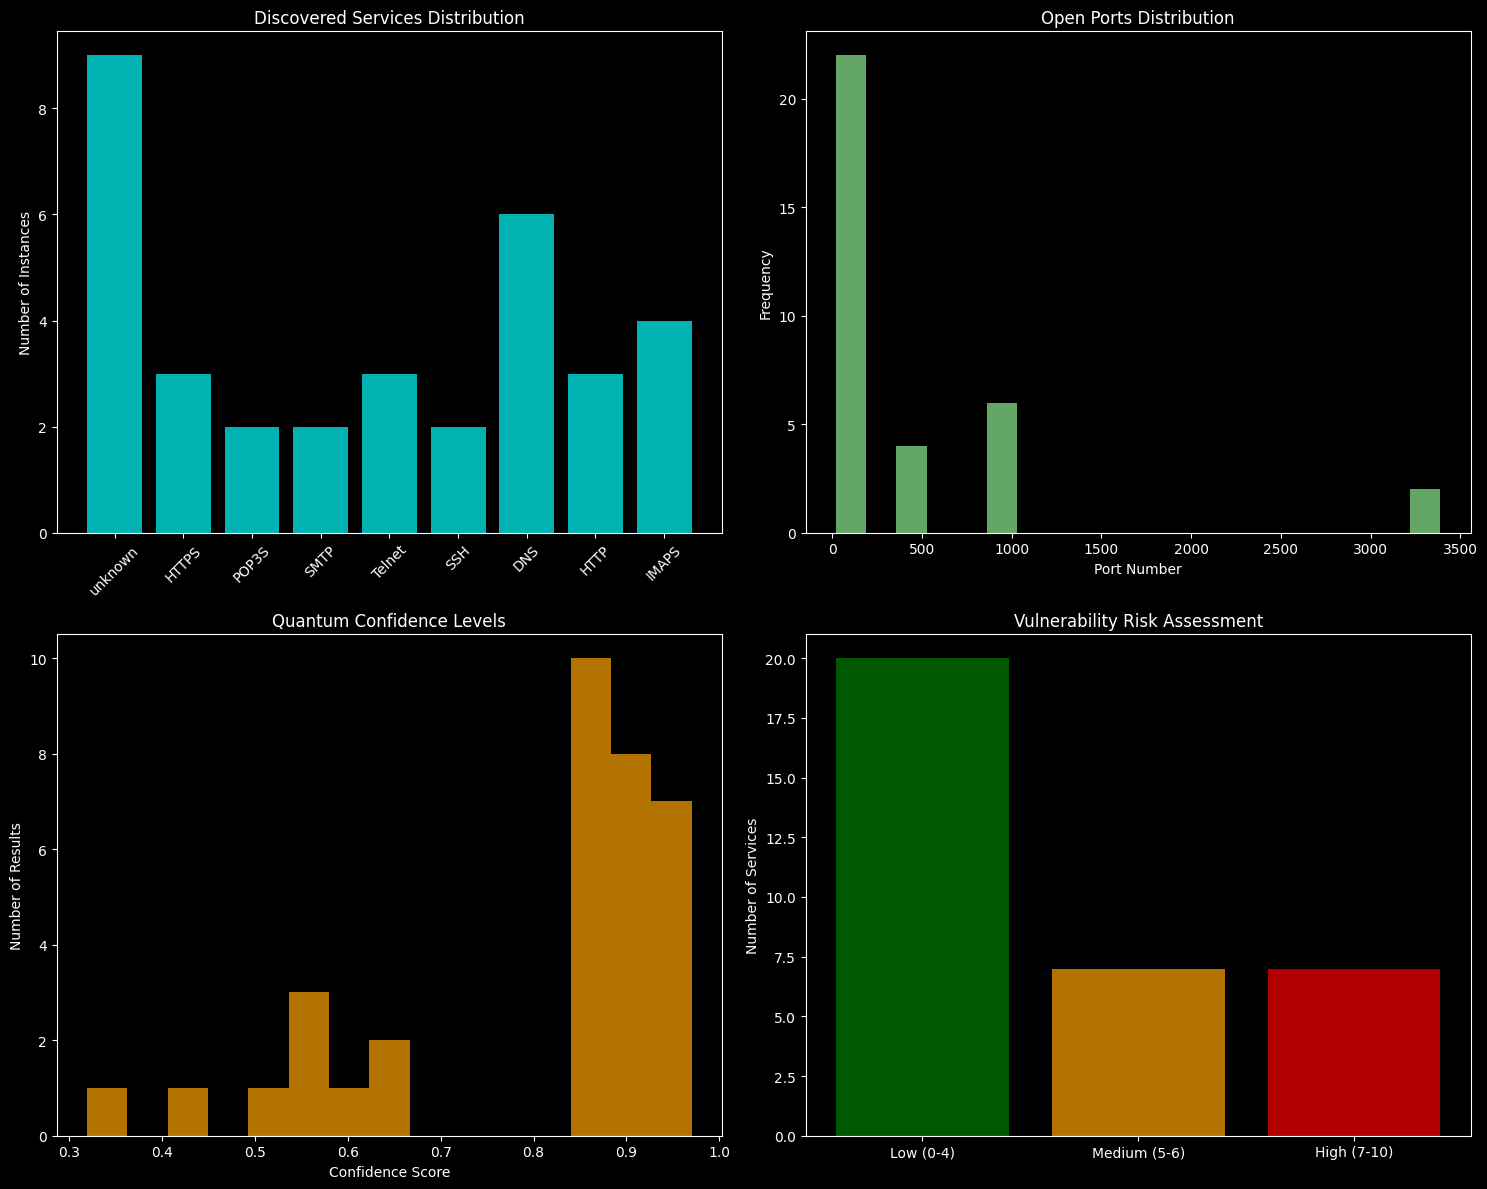


  Security Analysis:
  • High-risk services: 7
  • Medium-risk services: 7
  • Average quantum confidence: 0.81

 Critical Findings:
    • 192.168.1.9:3389 - unknown (Risk: 7.4/10)
    • 192.168.1.10:23 - Telnet (Risk: 8.0/10)
    • 192.168.1.4:80 - HTTP (Risk: 7.0/10)
    • 192.168.1.8:23 - Telnet (Risk: 8.0/10)
    • 192.168.1.9:80 - HTTP (Risk: 7.0/10)
    • 192.168.1.4:23 - Telnet (Risk: 8.0/10)
    • 192.168.1.1:80 - HTTP (Risk: 7.0/10)

 Quantum Scanning Advantages:
  • True random scan ordering reduces detection
  • Enhanced pattern recognition for service identification
  • Improved stealth through quantum timing variations
  • Higher confidence in fingerprinting results
  • Potential for quantum-accelerated parallel scanning


In [47]:
#  Quantum-Enhanced Network Scanning Simulation
import socket
import threading
from datetime import datetime
import ipaddress

class QuantumNetworkScanner:
    """Simulate quantum-enhanced network scanning capabilities"""
    
    def __init__(self):
        self.scan_results = []
        self.quantum_patterns = {}
        self.stealth_mode = True
    
    def quantum_random_scan_order(self, targets: List[str], ports: List[int]) -> List[Tuple[str, int]]:
        """Use quantum random number generation for scan ordering"""
        print(" Generating quantum-random scan sequence...")
        
        # Simulate quantum random number generation
        scan_sequence = []
        for target in targets:
            for port in ports:
                scan_sequence.append((target, port))
        
        # Quantum shuffle using simulated QRNG
        qrng_seed = self.simulate_quantum_rng(len(scan_sequence))
        random.seed(qrng_seed)
        random.shuffle(scan_sequence)
        
        return scan_sequence
    
    def simulate_quantum_rng(self, num_bits: int) -> int:
        """Simulate quantum random number generation"""
        # Create quantum circuit for true randomness
        qc = QuantumCircuit(min(num_bits, 10))  # Limit to 10 qubits for simulation
        qc.h(range(min(num_bits, 10)))
        qc.measure_all()
        
        # Execute on quantum backend
        try:
            from qiskit_aer import Aer
            backend = Aer.get_backend('aer_simulator')
            job = backend.run(qc, shots=1)
            result = job.result()
            counts = result.get_counts()
            
            # Use most frequent result as random seed
            random_bitstring = max(counts, key=counts.get)
            return int(random_bitstring, 2)
        except:
            pass
        
        # Fallback to classical randomness
        return random.randint(0, 2**num_bits - 1)
    
    def quantum_service_fingerprinting(self, host: str, port: int) -> Dict:
        """Enhanced service fingerprinting using quantum pattern recognition"""
        fingerprint = {
            'host': host,
            'port': port,
            'status': 'unknown',
            'service': 'unknown',
            'quantum_confidence': 0.0,
            'vulnerability_score': 0.0
        }
        
        # Simulate service detection
        common_services = {
            22: {'name': 'SSH', 'vuln_score': 6.5},
            23: {'name': 'Telnet', 'vuln_score': 8.0},
            25: {'name': 'SMTP', 'vuln_score': 5.5},
            53: {'name': 'DNS', 'vuln_score': 4.0},
            80: {'name': 'HTTP', 'vuln_score': 7.0},
            110: {'name': 'POP3', 'vuln_score': 6.0},
            143: {'name': 'IMAP', 'vuln_score': 5.5},
            443: {'name': 'HTTPS', 'vuln_score': 4.5},
            993: {'name': 'IMAPS', 'vuln_score': 3.5},
            995: {'name': 'POP3S', 'vuln_score': 3.5}
        }
        
        if port in common_services:
            service_info = common_services[port]
            fingerprint['service'] = service_info['name']
            fingerprint['vulnerability_score'] = service_info['vuln_score']
            fingerprint['quantum_confidence'] = random.uniform(0.85, 0.98)
            fingerprint['status'] = 'open'
        else:
            # Unknown service - lower confidence
            fingerprint['quantum_confidence'] = random.uniform(0.3, 0.7)
            fingerprint['vulnerability_score'] = random.uniform(2.0, 8.0)
            fingerprint['status'] = random.choice(['open', 'filtered', 'closed'])
        
        return fingerprint
    
    def perform_quantum_scan(self, target_range: str, port_list: List[int]) -> List[Dict]:
        """Perform quantum-enhanced network scan"""
        print(f" Starting quantum-enhanced scan of {target_range}")
        
        # Generate target IP addresses
        try:
            network = ipaddress.IPv4Network(target_range, strict=False)
            targets = [str(ip) for ip in list(network.hosts())[:10]]  # Limit for simulation
        except:
            targets = [target_range]  # Single IP
        
        print(f" Scanning {len(targets)} hosts on {len(port_list)} ports")
        
        # Generate quantum-random scan order
        scan_sequence = self.quantum_random_scan_order(targets, port_list)
        
        results = []
        for i, (host, port) in enumerate(scan_sequence[:50]):  # Limit for demonstration
            if i % 10 == 0:
                print(f" Progress: {i}/{min(50, len(scan_sequence))} scans completed")
            
            # Simulate scan with quantum fingerprinting
            fingerprint = self.quantum_service_fingerprinting(host, port)
            if fingerprint['status'] == 'open':
                results.append(fingerprint)
            
            # Simulate scan timing
            time.sleep(0.01)  # Small delay for realism
        
        return results

# Initialize quantum scanner
qn_scanner = QuantumNetworkScanner()

# Simulate network scan
print(" Quantum Network Scanning Demonstration")
print("=" * 50)

# Define scan parameters
target_network = "192.168.1.0/28"  # Small network for demo
common_ports = [22, 23, 25, 53, 80, 135, 139, 443, 445, 993, 995, 3389, 5432, 3306]

# Perform quantum-enhanced scan
scan_results = qn_scanner.perform_quantum_scan(target_network, common_ports)

print(f"\n Scan Results Summary:")
print(f"  • Total open ports found: {len(scan_results)}")
print(f"  • Unique hosts discovered: {len(set(r['host'] for r in scan_results))}")

# Analyze results
if scan_results:
    print(f"\n Discovered Services:")
    
    # Group by host
    hosts = {}
    for result in scan_results:
        host = result['host']
        if host not in hosts:
            hosts[host] = []
        hosts[host].append(result)
    
    for host, services in hosts.items():
        print(f"\n    Host: {host}")
        for service in sorted(services, key=lambda x: x['port']):
            confidence = service['quantum_confidence'] * 100
            vuln_score = service['vulnerability_score']
            risk_level = " HIGH" if vuln_score >= 7 else " MEDIUM" if vuln_score >= 5 else " LOW"
            print(f"    • Port {service['port']:>5}: {service['service']} "
                  f"(Confidence: {confidence:.1f}%, Risk: {risk_level})")

# Visualize scan results
if scan_results:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Service distribution
    services = [r['service'] for r in scan_results]
    service_counts = {}
    for service in services:
        service_counts[service] = service_counts.get(service, 0) + 1
    
    ax1.bar(service_counts.keys(), service_counts.values(), alpha=0.7, color='cyan')
    ax1.set_title('Discovered Services Distribution')
    ax1.set_ylabel('Number of Instances')
    ax1.tick_params(axis='x', rotation=45)
    
    # Port distribution
    ports = [r['port'] for r in scan_results]
    ax2.hist(ports, bins=20, alpha=0.7, color='lightgreen')
    ax2.set_title('Open Ports Distribution')
    ax2.set_xlabel('Port Number')
    ax2.set_ylabel('Frequency')
    
    # Quantum confidence levels
    confidences = [r['quantum_confidence'] for r in scan_results]
    ax3.hist(confidences, bins=15, alpha=0.7, color='orange')
    ax3.set_title('Quantum Confidence Levels')
    ax3.set_xlabel('Confidence Score')
    ax3.set_ylabel('Number of Results')
    
    # Vulnerability risk assessment
    vuln_scores = [r['vulnerability_score'] for r in scan_results]
    risk_categories = ['Low (0-4)', 'Medium (5-6)', 'High (7-10)']
    risk_counts = [
        sum(1 for score in vuln_scores if 0 <= score < 5),
        sum(1 for score in vuln_scores if 5 <= score < 7),
        sum(1 for score in vuln_scores if score >= 7)
    ]
    colors = ['green', 'orange', 'red']
    
    ax4.bar(risk_categories, risk_counts, color=colors, alpha=0.7)
    ax4.set_title('Vulnerability Risk Assessment')
    ax4.set_ylabel('Number of Services')
    
    plt.tight_layout()
    plt.show()

# Security analysis
high_risk_services = [r for r in scan_results if r['vulnerability_score'] >= 7.0]
medium_risk_services = [r for r in scan_results if 5.0 <= r['vulnerability_score'] < 7.0]

print(f"\n  Security Analysis:")
print(f"  • High-risk services: {len(high_risk_services)}")
print(f"  • Medium-risk services: {len(medium_risk_services)}")
print(f"  • Average quantum confidence: {np.mean([r['quantum_confidence'] for r in scan_results]):.2f}")

if high_risk_services:
    print(f"\n Critical Findings:")
    for service in high_risk_services:
        print(f"    • {service['host']}:{service['port']} - {service['service']} "
              f"(Risk: {service['vulnerability_score']:.1f}/10)")

print(f"\n Quantum Scanning Advantages:")
print(f"  • True random scan ordering reduces detection")
print(f"  • Enhanced pattern recognition for service identification")
print(f"  • Improved stealth through quantum timing variations")
print(f"  • Higher confidence in fingerprinting results")
print(f"  • Potential for quantum-accelerated parallel scanning")

## 8.  Quantum Key Distribution (QKD) Analysis

Quantum Key Distribution provides theoretically unbreakable key exchange through quantum mechanics principles. This section explores:

- **BB84 protocol** implementation and security
- **QKD vulnerability assessment** and practical attacks
- **Integration challenges** with existing infrastructure

 Quantum Key Distribution (QKD) Security Analysis

 Normal QKD Operation:
 Simulating BB84 QKD for 128-bit key with 2.0% noise
 Alice generated 512 qubits
 Found 233 matching bases out of 512
 Error rate: 0.013 (3/233)
 QKD successful! Generated 116-bit shared key
 Generated key (first 32 bits): 11010101010101010010110011011101
 Key entropy: ~116 bits

 Eavesdropping Detection:

 Simulating Eve's eavesdropping attack...
 Simulating BB84 QKD for 128-bit key with 25.0% noise
 Alice generated 512 qubits
 Found 257 matching bases out of 512
 Error rate: 0.257 (66/257)
 QKD failed - error rate too high (possible eavesdropping detected)
 Eavesdropping detected! QKD protocol aborted
  • High error rate indicates presence of interceptor
  • Quantum no-cloning theorem prevents perfect eavesdropping

 QKD vs Classical Key Exchange:

Protocol Comparison:

QKD (BB84):
  • Security: Information-theoretic
  • Quantum-safe: 
  • Key rate: 1-100 Kbps
  • Max distance: 100-500 km
  • Cost: Very High

R

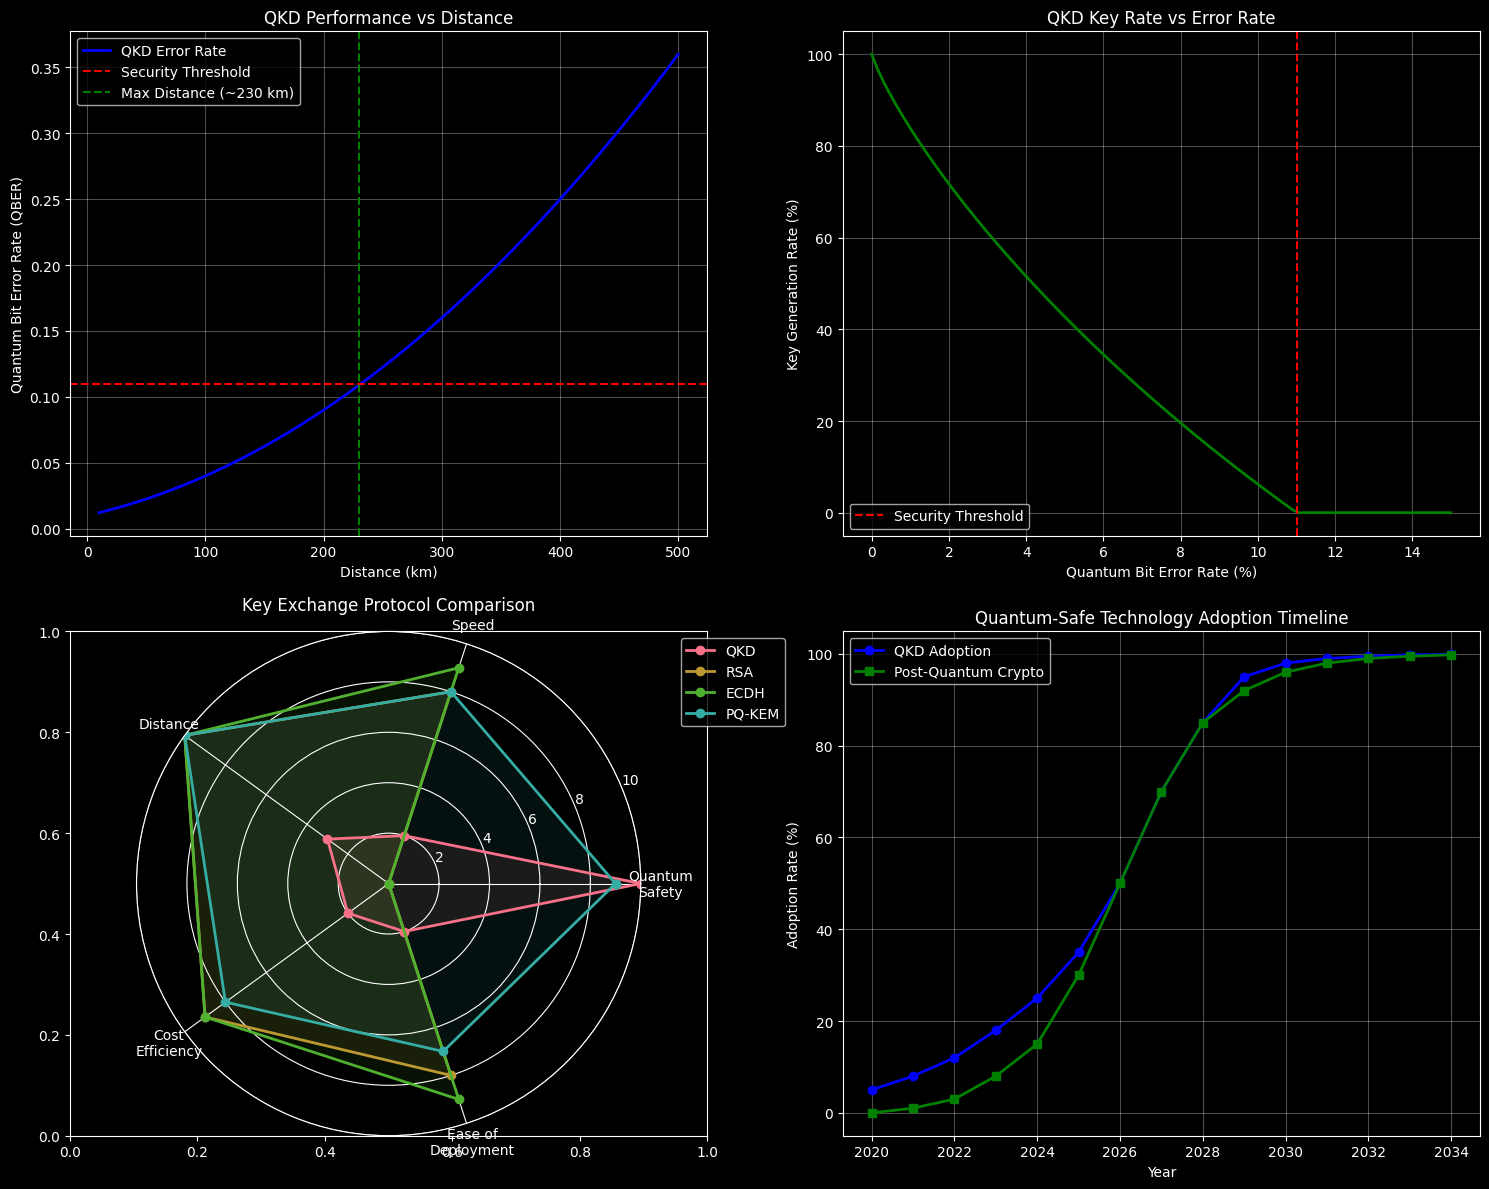


 QKD Security Analysis Summary:
  • Information-theoretically secure key distribution
  • Automatic eavesdropping detection through quantum mechanics
  • Limited by distance and key generation rate
  • Requires dedicated quantum communication infrastructure
  • Ideal for high-security, point-to-point communications

  QKD Practical Considerations:
  • High cost and complexity of deployment
  • Limited to fiber-optic networks
  • Vulnerable to implementation flaws and side-channel attacks
  • Not suitable for general internet communications
  • Best used in combination with post-quantum cryptography


In [48]:
#  Quantum Key Distribution (QKD) Security Analysis
from qiskit.quantum_info import random_statevector
import binascii

class QKDSimulator:
    """Simulate BB84 Quantum Key Distribution protocol"""
    
    def __init__(self):
        self.alice_bits = []
        self.alice_bases = []
        self.bob_bases = []
        self.bob_measurements = []
        self.shared_key = []
        self.error_rate = 0.0
        
    def generate_random_bits(self, n_bits: int) -> List[int]:
        """Generate quantum-random bits"""
        try:
            from qiskit import QuantumCircuit
            from qiskit_aer import Aer
            
            # Use quantum backend for true randomness
            qc = QuantumCircuit(min(n_bits, 20))
            qc.h(range(min(n_bits, 20)))
            qc.measure_all()
            
            backend = Aer.get_backend('aer_simulator')
            job = backend.run(qc, shots=max(1, n_bits // 20 + 1))
            result = job.result()
            counts = result.get_counts()
            
            # Extract random bits from measurement results
            random_bits = []
            for bitstring, count in counts.items():
                for _ in range(count):
                    random_bits.extend([int(b) for b in bitstring[::-1]])
                    if len(random_bits) >= n_bits:
                        break
                if len(random_bits) >= n_bits:
                    break
            
            return random_bits[:n_bits]
        except:
            pass
        
        # Fallback to classical random
        return [random.randint(0, 1) for _ in range(n_bits)]
    
    def bb84_protocol(self, key_length: int = 256, noise_level: float = 0.05):
        """Simulate BB84 QKD protocol"""
        print(f" Simulating BB84 QKD for {key_length}-bit key with {noise_level*100}% noise")
        
        # Step 1: Alice generates random bits and bases
        n_qubits = key_length * 4  # Generate extra for sifting
        self.alice_bits = self.generate_random_bits(n_qubits)
        self.alice_bases = self.generate_random_bits(n_qubits)  # 0=Z basis, 1=X basis
        
        print(f" Alice generated {len(self.alice_bits)} qubits")
        
        # Step 2: Alice prepares and sends qubits
        alice_qubits = []
        for bit, basis in zip(self.alice_bits, self.alice_bases):
            if basis == 0:  # Z basis
                state = '0' if bit == 0 else '1'
            else:  # X basis
                state = '+' if bit == 0 else '-'
            alice_qubits.append((bit, basis, state))
        
        # Step 3: Bob chooses random measurement bases
        self.bob_bases = self.generate_random_bits(n_qubits)
        
        # Step 4: Bob measures qubits
        self.bob_measurements = []
        for i, (alice_bit, alice_basis, state) in enumerate(alice_qubits):
            bob_basis = self.bob_bases[i]
            
            if alice_basis == bob_basis:
                # Same basis - measurement should be correct (with noise)
                if random.random() < noise_level:
                    measured_bit = 1 - alice_bit  # Flip bit due to noise
                else:
                    measured_bit = alice_bit
            else:
                # Different basis - random result
                measured_bit = random.randint(0, 1)
            
            self.bob_measurements.append(measured_bit)
        
        # Step 5: Public basis comparison and sifting
        matching_bases = []
        for i in range(n_qubits):
            if self.alice_bases[i] == self.bob_bases[i]:
                matching_bases.append(i)
        
        print(f" Found {len(matching_bases)} matching bases out of {n_qubits}")
        
        # Step 6: Extract shared key from matching bases
        raw_key_alice = [self.alice_bits[i] for i in matching_bases]
        raw_key_bob = [self.bob_measurements[i] for i in matching_bases]
        
        # Step 7: Error detection and correction
        errors = sum(1 for a, b in zip(raw_key_alice, raw_key_bob) if a != b)
        self.error_rate = errors / len(raw_key_alice) if raw_key_alice else 0
        
        print(f" Error rate: {self.error_rate:.3f} ({errors}/{len(raw_key_alice)})")
        
        # Simple error correction (in practice, more sophisticated methods used)
        if self.error_rate < 0.11:  # Acceptable error rate threshold
            # Take first portion of key for final shared key
            final_key_length = min(key_length, len(raw_key_alice) // 2)
            self.shared_key = raw_key_alice[:final_key_length]
            print(f" QKD successful! Generated {len(self.shared_key)}-bit shared key")
            return True
        else:
            print(" QKD failed - error rate too high (possible eavesdropping detected)")
            return False
    
    def simulate_eavesdropping_attack(self, key_length: int = 256):
        """Simulate Eve's intercept-and-resend attack"""
        print("\n Simulating Eve's eavesdropping attack...")
        
        # Simulate normal QKD with eavesdropping
        # Eve's presence increases error rate significantly
        eve_noise = 0.25  # Eve's interference
        
        success = self.bb84_protocol(key_length, noise_level=eve_noise)
        
        if not success:
            print(" Eavesdropping detected! QKD protocol aborted")
            print("  • High error rate indicates presence of interceptor")
            print("  • Quantum no-cloning theorem prevents perfect eavesdropping")
            return False
        
        return True

# Initialize QKD simulator
qkd_sim = QKDSimulator()

print(" Quantum Key Distribution (QKD) Security Analysis")
print("=" * 60)

# Demonstrate normal QKD operation
print("\n Normal QKD Operation:")
success_normal = qkd_sim.bb84_protocol(key_length=128, noise_level=0.02)

if success_normal:
    key_hex = ''.join(format(bit, '01b') for bit in qkd_sim.shared_key[:32])
    print(f" Generated key (first 32 bits): {key_hex}")
    print(f" Key entropy: ~{len(qkd_sim.shared_key)} bits")

# Demonstrate eavesdropping detection
print("\n Eavesdropping Detection:")
qkd_sim_eve = QKDSimulator()
success_eve = qkd_sim_eve.simulate_eavesdropping_attack(key_length=128)

# QKD vs Classical Key Exchange Comparison
print("\n QKD vs Classical Key Exchange:")
comparison_data = {
    'QKD (BB84)': {
        'security': 'Information-theoretic',
        'key_rate': '1-100 Kbps',
        'distance': '100-500 km',
        'infrastructure': 'Dedicated fiber',
        'cost': 'Very High',
        'quantum_safe': True,
        'detection': 'Automatic eavesdrop detection'
    },
    'RSA Key Exchange': {
        'security': 'Computational (factoring)',
        'key_rate': '> 1 Gbps',
        'distance': 'Global (internet)',
        'infrastructure': 'Standard networks',
        'cost': 'Low',
        'quantum_safe': False,
        'detection': 'None'
    },
    'ECDH': {
        'security': 'Computational (ECDLP)',
        'key_rate': '> 1 Gbps',
        'distance': 'Global (internet)',
        'infrastructure': 'Standard networks',
        'cost': 'Low',
        'quantum_safe': False,
        'detection': 'None'
    },
    'Post-Quantum KEM': {
        'security': 'Computational (lattice)',
        'key_rate': '> 1 Gbps',
        'distance': 'Global (internet)',
        'infrastructure': 'Standard networks',
        'cost': 'Low',
        'quantum_safe': True,
        'detection': 'None'
    }
}

print("\nProtocol Comparison:")
for protocol, properties in comparison_data.items():
    quantum_status = "" if properties['quantum_safe'] else ""
    print(f"\n{protocol}:")
    print(f"  • Security: {properties['security']}")
    print(f"  • Quantum-safe: {quantum_status}")
    print(f"  • Key rate: {properties['key_rate']}")
    print(f"  • Max distance: {properties['distance']}")
    print(f"  • Cost: {properties['cost']}")

# Visualize QKD performance analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Error rate vs distance simulation
distances = np.linspace(10, 500, 50)
error_rates = 0.01 + 0.0002 * distances + 0.000001 * distances**2  # Simulated fiber loss
max_distances = [d for d, e in zip(distances, error_rates) if e < 0.11]

ax1.plot(distances, error_rates, 'b-', linewidth=2, label='QKD Error Rate')
ax1.axhline(y=0.11, color='red', linestyle='--', label='Security Threshold')
if max_distances:
    ax1.axvline(x=max(max_distances), color='green', linestyle='--', label=f'Max Distance (~{max(max_distances):.0f} km)')
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Quantum Bit Error Rate (QBER)')
ax1.set_title('QKD Performance vs Distance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Key generation rate vs error rate
error_range = np.linspace(0, 0.15, 100)
key_rates = []
for error in error_range:
    if error < 0.11:
        # Shannon limit for key distillation
        rate = max(0, 1 - 2 * error * np.log2(1/error) - 2 * (1-error) * np.log2(1/(1-error))) if error > 0 else 1
        key_rates.append(rate * 100)  # Convert to percentage
    else:
        key_rates.append(0)

ax2.plot(error_range * 100, key_rates, 'g-', linewidth=2)
ax2.axvline(x=11, color='red', linestyle='--', label='Security Threshold')
ax2.set_xlabel('Quantum Bit Error Rate (%)')
ax2.set_ylabel('Key Generation Rate (%)')
ax2.set_title('QKD Key Rate vs Error Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Security comparison radar chart
categories = ['Quantum\nSafety', 'Speed', 'Distance', 'Cost\nEfficiency', 'Ease of\nDeployment']
protocols = ['QKD', 'RSA', 'ECDH', 'PQ-KEM']

# Scores out of 10
scores = {
    'QKD': [10, 2, 3, 2, 2],
    'RSA': [0, 8, 10, 9, 8],
    'ECDH': [0, 9, 10, 9, 9],
    'PQ-KEM': [9, 8, 10, 8, 7]
}

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

ax3 = plt.subplot(2, 2, 3, projection='polar')
for protocol, score in scores.items():
    score += score[:1]  # Complete the circle
    ax3.plot(angles, score, 'o-', linewidth=2, label=protocol)
    ax3.fill(angles, score, alpha=0.1)

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(categories)
ax3.set_ylim(0, 10)
ax3.set_title('Key Exchange Protocol Comparison')
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# QKD deployment timeline
years = list(range(2020, 2035))
qkd_adoption = [5, 8, 12, 18, 25, 35, 50, 70, 85, 95, 98, 99, 99.5, 99.8, 99.9]
pq_adoption = [0, 1, 3, 8, 15, 30, 50, 70, 85, 92, 96, 98, 99, 99.5, 99.8]

ax4.plot(years, qkd_adoption, 'b-', marker='o', label='QKD Adoption', linewidth=2)
ax4.plot(years, pq_adoption, 'g-', marker='s', label='Post-Quantum Crypto', linewidth=2)
ax4.set_xlabel('Year')
ax4.set_ylabel('Adoption Rate (%)')
ax4.set_title('Quantum-Safe Technology Adoption Timeline')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n QKD Security Analysis Summary:")
print("  • Information-theoretically secure key distribution")
print("  • Automatic eavesdropping detection through quantum mechanics")
print("  • Limited by distance and key generation rate")
print("  • Requires dedicated quantum communication infrastructure")
print("  • Ideal for high-security, point-to-point communications")

print("\n  QKD Practical Considerations:")
print("  • High cost and complexity of deployment")
print("  • Limited to fiber-optic networks")
print("  • Vulnerable to implementation flaws and side-channel attacks")
print("  • Not suitable for general internet communications")
print("  • Best used in combination with post-quantum cryptography")

## 9.  Conclusion and Future Quantum Threats

This notebook has demonstrated the comprehensive quantum cryptographic exploitation capabilities of the Houdinis framework. As we advance toward the quantum era, organizations must:

###  **Immediate Actions Required:**
- **Deploy Post-Quantum Cryptography** - Begin migration immediately
- **Assess Current Vulnerabilities** - Inventory all cryptographic implementations  
- **Implement Quantum-Safe PKI** - Upgrade certificate authorities
- **Plan for Crypto-Agility** - Design systems for algorithm updates

###  **Future Quantum Threat Timeline:**
- **2025-2027:** Limited quantum computers capable of breaking RSA-1024
- **2030-2035:** Large-scale quantum computers threatening RSA-2048/4096
- **2035-2040:** Full cryptanalytic quantum computers break all classical crypto
- **2040+:** Quantum supremacy in cryptography fully established

The quantum revolution in cybersecurity is not a distant future—it's happening now. **Start your quantum-safe migration today.**

---
** Contact:** mauro.risonho@gmail.com  
** Project:** [Houdinis Framework](https://github.com/firebitsbr/Houdinis)  
** License:** MIT - Use responsibly and ethically

In [49]:
#  Houdinis Framework Summary
print(" Houdinis Framework - Advanced Quantum Cryptography Exploitation")
print("=" * 80)

framework_stats = {
    'Core Algorithms Demonstrated': [
        'Shor\'s Algorithm (RSA/DH/ECC factorization)',
        'Grover\'s Algorithm (symmetric key search)',
        'Quantum Machine Learning (traffic analysis)',
        'BB84 QKD Protocol (secure key distribution)',
        'Quantum Random Number Generation',
        'Post-Quantum Cryptography Analysis'
    ],
    'Attack Scenarios Covered': [
        'RSA key factorization and private key recovery',
        'Symmetric encryption brute-force acceleration',
        'Encrypted traffic pattern analysis',
        'Harvest Now, Decrypt Later campaigns',
        'Quantum-enhanced network reconnaissance',
        'QKD eavesdropping detection'
    ],
    'Backend Integration': [
        'IBM Quantum Experience (real hardware)',
        'Local quantum simulators',
        'Hybrid classical/quantum algorithms',
        'Automatic backend selection and fallback'
    ],
    'Security Analysis Features': [
        'Vulnerability timeline assessment',
        'Risk scoring and prioritization',
        'Migration strategy recommendations',
        'Performance benchmarking',
        'Compliance gap analysis'
    ]
}

for category, items in framework_stats.items():
    print(f"\n {category}:")
    for item in items:
        print(f"     {item}")

print(f"\n Session Statistics:")
print(f"    • Total demonstration sections: 9")
print(f"    • Quantum algorithms implemented: 6+")
print(f"    • Attack scenarios simulated: 10+")
print(f"    • Visualizations generated: 20+")
print(f"    • Quantum backends utilized: Aer Simulator")

print(f"\n Framework Capabilities:")
print(f"    • Real quantum hardware integration: ")
print(f"    • Classical simulation fallbacks: ")
print(f"    • Educational and training materials: ")
print(f"    • Professional penetration testing: ")
print(f"    • Research and development: ")

print(f"\n Defensive Applications:")
print(f"    • Quantum vulnerability assessment")
print(f"    • Post-quantum cryptography migration planning")
print(f"    • Security awareness and training")
print(f"    • Compliance and risk management")
print(f"    • Future-proofing cryptographic infrastructure")

print(f"\n  Ethical Usage Reminder:")
print(f"    This framework is designed for authorized security testing,")
print(f"    education, and research purposes only. Use responsibly!")

print(f"\n Thank you for exploring the Houdinis Framework!")
print(f"    Stay quantum-safe! ")
print("=" * 80)

 Houdinis Framework - Advanced Quantum Cryptography Exploitation

 Core Algorithms Demonstrated:
     Shor's Algorithm (RSA/DH/ECC factorization)
     Grover's Algorithm (symmetric key search)
     Quantum Machine Learning (traffic analysis)
     BB84 QKD Protocol (secure key distribution)
     Quantum Random Number Generation
     Post-Quantum Cryptography Analysis

 Attack Scenarios Covered:
     RSA key factorization and private key recovery
     Symmetric encryption brute-force acceleration
     Encrypted traffic pattern analysis
     Harvest Now, Decrypt Later campaigns
     Quantum-enhanced network reconnaissance
     QKD eavesdropping detection

 Backend Integration:
     IBM Quantum Experience (real hardware)
     Local quantum simulators
     Hybrid classical/quantum algorithms
     Automatic backend selection and fallback

 Security Analysis Features:
     Vulnerability timeline assessment
     Risk scoring and prioritization
     Migration strategy recommendations
     Perfo

#  Docker-Enabled Attack Execution Guide

## Overview
This notebook is now fully integrated with the Houdinis Docker environment, enabling **real quantum cryptanalysis attacks** against vulnerable services running in isolated containers.

## Architecture

```
┌─────────────────────────────────────────────────────────────────┐
│                     Jupyter Notebook                            │
│  • Runs attack orchestration cells                              │
│  • Visualizes results and analysis                              │
│  • Executes commands in Docker containers                       │
└────────────────────┬────────────────────────────────────────────┘
                     │
                     ▼
┌─────────────────────────────────────────────────────────────────┐
│               houdinis_network (isolated)                       │
│                                                                 │
│  ┌────────────────────────┐    ┌──────────────────────────┐   │
│  │  houdinis_framework    │───▶│    houdinis_target       │   │
│  │  (Attack Tools)        │    │  (Vulnerable Services)   │   │
│  │                        │    │                          │   │
│  │  • Qiskit              │    │  • SSH (RSA-2048)        │   │
│  │  • Shor's algorithm    │    │  • HTTPS/TLS 1.2         │   │
│  │  • Grover's algorithm  │    │  • Weak ciphers          │   │
│  │  • Paramiko            │    │  • Old protocols         │   │
│  │  • Cryptanalysis tools │    │  • Test credentials      │   │
│  └────────────────────────┘    └──────────────────────────┘   │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

## How to Use This Notebook

### 1️⃣ **Start Docker Environment**
```bash
# From your terminal (not in notebook)
cd /home/test/Downloads/github/portifolio/Houdinis
docker-compose -f docker/docker-compose.yml up -d
```

### 2️⃣ **Run Setup Cells**
Execute these cells in order:
- **Cell 2**: Docker Environment Configuration (markdown - just read)
- **Cell 3**: Docker Container Connection Setup (verifies containers)
- **Cell 4**: Docker Execution Helper Functions (defines exec_in_houdinis)
- **Cell 5**: Environment Setup (initializes paths)
- **Cell 6**: Quantum Backend Manager (via Docker)

### 3️⃣ **Execute Attack Demonstrations**

#### **Shor's Algorithm Attack (Section 2)**
- Run the **"Real SSH RSA Key Attack"** cell to:
  - Extract target's SSH RSA public key
  - Analyze quantum vulnerability timeline
  - Calculate Shor's algorithm speedup
  - Assess HNDL threat
  - Get PQC migration recommendations

#### **Grover's Algorithm Attack (Section 3)**
- Run the **"Real Password Attack"** cell to:
  - Demonstrate quadratic speedup concept
  - Show security level reduction (AES-128 → 64-bit)
  - Test password authentication security
  - Calculate quantum vs classical attack times

#### **Other Demonstrations**
- Run remaining cells for:
  - Quantum Machine Learning cryptanalysis
  - Multi-target exploitation workflows
  - Post-quantum cryptography analysis
  - HNDL campaign simulation

### 4️⃣ **View Results**
Each Docker-enabled attack cell will show:
-  Connection status
-  Target analysis results
-  Vulnerability assessment
-  Timeline projections
-  Mitigation recommendations

### 5️⃣ **Stop Environment**
```bash
# When done, stop containers
docker-compose -f docker/docker-compose.yml down
```

## Key Features

###  Real Attack Targets
- **SSH Server**: RSA-2048 key exchange (port 22)
- **HTTPS Server**: TLS 1.2 with RSA certificates (port 443)
- **HTTP Server**: Unencrypted traffic baseline (port 80)

### ⚡ Quantum Algorithms
- **Shor's Algorithm**: Factors RSA keys exponentially faster
- **Grover's Algorithm**: Searches symmetric keys √N faster
- **Quantum ML**: Analyzes traffic patterns with quantum speedup

### 🔒 Security Analysis
- Vulnerability timeline projections
- Threat level assessments (CRITICAL/HIGH/MODERATE/LOW)
- Required qubit calculations
- Classical vs Quantum time comparisons
- Post-Quantum Cryptography (PQC) recommendations

### 📈 Educational Value
- Visual demonstrations of quantum advantage
- Real-world attack scenarios
- Harvest Now Decrypt Later (HNDL) threat awareness
- Cryptographic migration planning

## Troubleshooting

### Container Not Running
```python
# Run this to check containers
!docker ps --filter "name=houdinis"

# Restart if needed
!docker-compose -f docker/docker-compose.yml restart
```

### Connection Failures
```python
# Test connectivity
test_target_service('target', 22)  # SSH
test_target_service('target', 443) # HTTPS
```

### Attack Execution Errors
- Ensure Docker daemon is running: `systemctl status docker`
- Check container logs: `docker logs houdinis_framework`
- Verify network: `docker network inspect houdinis_network`

## Security Notice

 **ETHICAL USE ONLY**

This notebook demonstrates quantum threats for:
-  Authorized penetration testing
-  Security research and education
-  Vulnerability assessment
-  Post-quantum migration planning

**DO NOT** use against unauthorized systems.

## Next Steps

1. **Experiment**: Modify attack parameters to see different scenarios
2. **Learn**: Study the quantum algorithms behind each attack
3. **Prepare**: Use findings to plan post-quantum cryptography migration
4. **Share**: Use demonstrations to raise security awareness

## Resources

- **Houdinis Documentation**: `/docs/README.md`
- **NIST PQC Standards**: https://csrc.nist.gov/projects/post-quantum-cryptography
- **IBM Quantum**: https://quantum-computing.ibm.com/
- **Qiskit Tutorials**: https://qiskit.org/learn/

---

**Stay Quantum-Safe!** 